In [1]:
# import datetime
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web


#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }

inflation_target = 2

unemployment_target = 4
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


In [2]:

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days

if "data_gathered" not in locals():
    data = gather_data(data_codes, start, 
          end = end, freq = freq)
    data.fillna(0, inplace=True)
    for key in data.keys():
        data["Log " + key]= np.log(data[key])
    data_gathered = True

data["Base: Currency in Circulation ($ Mil)"] = data["Base: Currency in Circulation ($ Bil)"].mul(1000)
data["Base: Currency not in Circulation ($ Mil)"] = data["Base: Total ($ Mil)"].sub(data["Base: Currency in Circulation ($ Mil)"])
data["Currency in Circulation Growth Rate (%)"] = data["Base: Currency in Circulation ($ Mil)"].pct_change(year) * 100
data["Currency in Circulation Growth Rate Diff (%)"] =  data["Currency in Circulation Growth Rate (%)"].diff(year)
data["Currency in Circulation Growth Rate Diff-in-Diff (%)"] =  data["Currency in Circulation Growth Rate Diff (%)"].diff(year)

data["% Currency not in Circulation"] = data["Base: Currency not in Circulation ($ Mil)"].div(data["Base: Total ($ Mil)"]) * 100
data["% Currency in Circulation"] = data["Base: Currency in Circulation ($ Mil)"].div(data["Base: Total ($ Mil)"]) * 100
data["Base: Total Growth Rate (%)"] = data["Base: Total ($ Mil)"]
data["Change % Currency not in Circulation"] = data["% Currency not in Circulation"].diff(year)    
data["Currency not in Circulation Growth Rate (%)"] = data["Base: Currency not in Circulation ($ Mil)"].pct_change(year) * 100    
data["Inflation (CPI)"] =  web.DataReader("CPIAUCSL", "fred", start, end).resample(freq).mean().pct_change(year).mul(100)
data["Inflation (PCE)"] = web.DataReader("PCEPILFE", "fred", start, end).resample(freq).mean().pct_change(year).mul(100)

data["Effective Federal Funds Rate Diff (%)"] = data["Effective Federal Funds Rate (%)"].diff(year)
data["Effective Federal Funds Rate Diff-in-Diff (%)"] = data["Effective Federal Funds Rate Diff (%)"].diff(year)
data["1 Year Treasury Rate (%; diff)"] = data["1 Year Treasury Rate (%)"].diff(year)
data["2 Year Treasury Rate (%; diff)"] = data["2 Year Treasury Rate (%)"].diff(year)
data["10 Year Treasury Rate (%; diff)"] = data["10 Year Treasury Rate (%)"].diff(year)
data["30 Year Treasury Rate (%; diff)"] = data["30 Year Treasury Rate (%)"].diff(year)
data["Unemployment Rate Diff"] = data["Unemployment Rate"].diff(year)
data["Unemployment Rate Diff-in-Diff"] = data["Unemployment Rate Diff"].diff(year)
data["Nominal GDP ($ Mil)"] = data["Nominal GDP ($ Bil)"].mul(1000)
data["Nominal GDP Growth Rate (%)"] = data["Nominal GDP ($ Bil)"].pct_change(year) * 100
data["Real GDP ($ Mil)"] = data["Real GDP ($ Bil)"].mul(1000)
data["Real GDP Growth Rate (%)"] = data["Real GDP ($ Bil)"].pct_change(year) * 100
data["Inflation (GDPDEF)"] = data["GDP Deflator"].pct_change(year) * 100
data["Real Currency in Circulation Growth Rate (%)"] = data["Currency in Circulation Growth Rate (%)"].sub(data["Inflation (GDPDEF)"])
data["Currency in Circulation Velocity"] = data["Nominal GDP ($ Mil)"].div(data["Base: Currency in Circulation ($ Mil)"])
data["Currency in Circulation % Change Velocity"] = data["Currency in Circulation Velocity"].pct_change(year)

data["Inflation Loss"]= data["Inflation (PCE)"].sub(inflation_target)
data["Unemployment Loss"]= data["Unemployment Rate"].sub(unemployment_target)
data["Inflation Loss Sq"]= data["Inflation (PCE)"].sub(inflation_target).pow(2)
data["Inflation Loss Sq"][data["Inflation Loss"] < 0] = data["Inflation Loss Sq"].mul(-1)

data["Unemployment Loss Sq"]= data["Unemployment Rate"].sub(unemployment_target).pow(2)
data["Unemployment Loss Sq"][data["Unemployment Loss"] < 0] = data["Unemployment Loss Sq"].mul(-1)



data["Inflation Loss Diff"]= data["Inflation Loss"].diff(year)
data["Unemployment Loss Diff"]= data["Unemployment Loss"].diff(year)
data["Inflation Loss Sq Diff"]= data["Inflation Loss Sq"].diff(year)
data["Unemployment Loss Sq Diff"]= data["Unemployment Loss Sq"].diff(year)

data["Inflation Loss Diff-in-Diff"]= data["Inflation Loss Diff"].diff(year)
data["Unemployment Loss Diff-in-Diff"]= data["Unemployment Loss Diff"].diff(year)
data["Inflation Loss Sq Diff-in-Diff"]= data["Inflation Loss Sq Diff"].diff(year)
data["Unemployment Loss Sq Diff-in-Diff"]= data["Unemployment Loss Sq Diff"].diff(year)


data["Linear Loss"] = data["Inflation Loss"].sub(data["Unemployment Loss"])
data["Loss Function"] = data["Inflation Loss Sq"].sub(data["Unemployment Loss Sq"])
data["Linear Loss Diff"] = data["Linear Loss"].diff(year)
data["Loss Function Diff"] = data["Loss Function"].diff(year)
data["Linear Loss Diff-in-Diff"] = data["Linear Loss Diff"].diff(year)
data["Loss Function Diff-in-Diff"] = data["Loss Function Diff"].diff(year)

data["Real 1 Year Treasury Rate"] = data["1 Year Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real 3 Month Treasury Rate"] = data["3 Month Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real 1 Month Treasury Rate"] = data["1 Month Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real Effective Federal Funds Rate"] = data['Effective Federal Funds Rate (%)'].sub(data["Inflation (CPI)"])

data["30 Year Minus 1 Year (%)"] = data["30 Year Treasury Rate (%)"].sub(data["1 Year Treasury Rate (%)"])
data["30 Year Minus 3 Month (%)"] = data["30 Year Treasury Rate (%)"].sub(data["3 Month Treasury Rate (%)"])
data["30 Year Minus 1 Month (%)"] = data["30 Year Treasury Rate (%)"].sub(data["1 Month Treasury Rate (%)"])
data["30 Year Minus Effective Federal Funds Rate"] = data["30 Year Treasury Rate (%)"].sub(data['Effective Federal Funds Rate (%)'])
data["10 Year Minus 2 Year (%)"] = data["10 Year Treasury Rate (%)"].sub(data["2 Year Treasury Rate (%)"])
data["10 Year Minus 1 Year (%)"] = data["10 Year Treasury Rate (%)"].sub(data["1 Year Treasury Rate (%)"])
data["10 Year Minus 3 Month (%)"] = data["10 Year Treasury Rate (%)"].sub(data["3 Month Treasury Rate (%)"])
data["10 Year Minus 1 Month (%)"] = data["10 Year Treasury Rate (%)"].sub(data["1 Month Treasury Rate (%)"])
data["10 Year Minus Effective Federal Funds Rate"] = data["10 Year Treasury Rate (%)"].sub(data['Effective Federal Funds Rate (%)'])


## these variables will be used for balance sheet stackplots
#   in particular, Variables starting with "Other" are used to fill in the remaining area
#   of a stackplot not covered by primary asset holdings // liability offerings
data["Balance Sheet: Direct Lending and Central Bank Liquidity Swaps"] =\
    data["Balance Sheet: Central Bank Liquidity Swaps ($ Mil)"].add(
    data["Balance Sheet: Direct Lending ($ Mil)"])
data["Balance Sheet: Other Securities"] = data["Balance Sheet: Securities Held Outright ($ Mil)"].sub(
    data["Balance Sheet: U.S. Treasuries Held Outright ($ Mil)"]).sub(
    data["Balance Sheet: Mortgage-Backed Securities ($ Mil)"])
data["Balance Sheet: Other Assets"] = data["Balance Sheet: Total Assets ($ Mil)"].sub(
    data["Balance Sheet: Securities Held Outright ($ Mil)"]).sub(
    data["Balance Sheet: Direct Lending and Central Bank Liquidity Swaps"]).sub(
    data["Balance Sheet: Repos ($ Mil)"]).sub(
    data["Balance Sheet: Unamortized Security Premiums ($ Mil)"])
data["Balance Sheet: Other Deposits ($ Mil)"] = data["Balance Sheet: All Deposits ($ Mil)"].sub(
    data["Balance Sheet: U.S. Treasury General Account ($ Mil)"]).sub(
    data["Balance Sheet: Deposits from Dep. Institutions ($ Mil)"])
data["Balance Sheet: Other Liabilities"]= data["Balance Sheet: Total Liabilities ($ Mil)"].sub(
    data["Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)"]).sub(
    data["Balance Sheet: U.S. Treasury General Account ($ Mil)"]).sub(
    data["Balance Sheet: Deposits from Dep. Institutions ($ Mil)"]).sub(
    data["Balance Sheet: Other Deposits ($ Mil)"]).sub(
    data["Balance Sheet: Reverse Repos ($ Mil)"])
data["VIX Diff"] = data["VIX"].diff(year)

keys = list(data.keys())
keys = ["Date"] + keys
data["Date"] = data.index.astype(str)

C:\Users\JLCat\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
data = data.rename(columns = {
    key: key.replace("Balance Sheet: ", "").replace(" ($ Mil)", "").replace("Base: ","") for key in data.keys()})
data["Net Effect on Overnight Lending Market"] =\
    data["Repos"].sub(data["Reverse Repos"])
data["Total Liabilities Growth Rate (%)"] = data["Total Liabilities"].pct_change(year)
data["Total Assets Growth Rate (%)"] = data["Total Assets"].pct_change(year)
data["Total Assets Growth Rate Diff (%)"] = data["Total Assets Growth Rate (%)"].diff(year)
data["Total Assets Growth Rate Diff-in-Diff (%)"] = data["Total Assets Growth Rate Diff (%)"].diff(year)

data["Total Liabilities / Currency in Circulation"] = data["Total Liabilities"].div(data["Currency in Circulation ($ Bil)"].mul(1000))
data["Total Assets / Currency in Circulation"] = data["Total Assets"].div(data["Currency in Circulation ($ Bil)"].mul(1000))
data["Currency in Circulation / Total Assets"] = data["Currency in Circulation ($ Bil)"].mul(1000).div(data["Total Assets"]).mul(100)
data["Currency in Circulation / Total Assets Diff"] = data["Currency in Circulation / Total Assets"].diff(year)
data["Currency in Circulation / Total Assets Diff-in-Diff"] = data["Currency in Circulation / Total Assets Diff"].diff(year)
data["Currency in Circulation / Total Liabilities"] = data["Currency in Circulation ($ Bil)"].mul(1000).div(data["Total Liabilities"])
data["Currency in Circulation / Total Liabilities Diff"] = data["Currency in Circulation / Total Liabilities"].diff(year)

data["Log Total Liabilities"] = np.log(data["Total Liabilities"])
data["Log Total Assets"] = np.log(data["Total Assets"])
#data["Currency in Circulation / Total Liabilities %"] = data["Currency in Circulation / Total Liabilities"].pct_change()


## If data is already downloaded, you can just load it from parquet. If you need to restart kernel, consider commenting out previous two cells

In [ ]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
data.to_parquet("FedDAGData.parquet.gzip", compression = "gzip",
                    engine = "pyarrow")
data = pd.read_parquet("FedDAGData.parquet.gzip")

<ipython-input-6-3df2aa4fa2c4>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(round(y,2))+ "%" for y in y_vals])


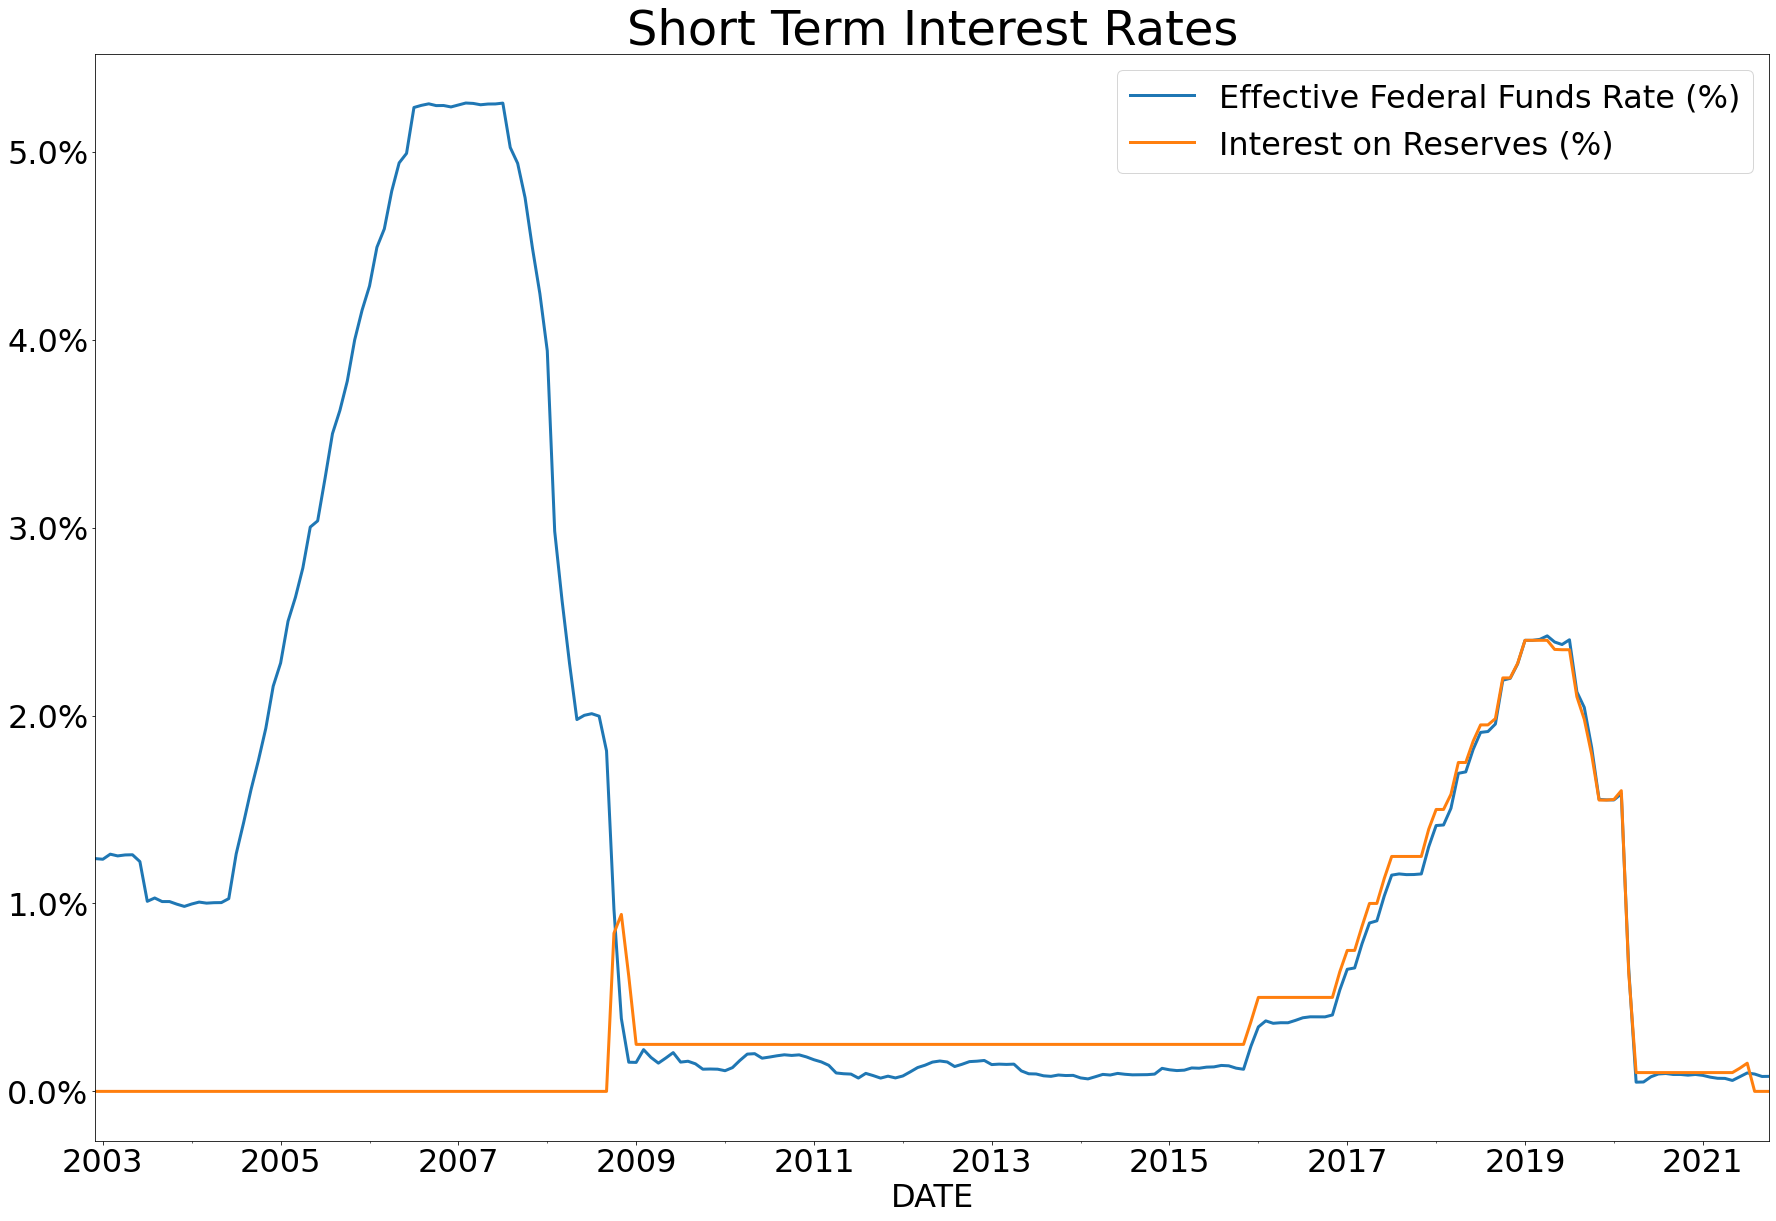

In [6]:
plt.rcParams.update({"font.size":32})
interest_vars = ["Effective Federal Funds Rate (%)",
                   "Interest on Reserves (%)"]
fig, ax = plt.subplots(figsize = (30,20))
data[interest_vars].plot.line(legend=True, linewidth = 3, ax = ax)
y_vals = ax.get_yticks()
ax.set_yticklabels([str(round(y,2))+ "%" for y in y_vals])  
ax.set_title("Short Term Interest Rates", fontsize = 48)
data[["Date"] + interest_vars].to_json("shortTermRates.json", orient="records")

In [7]:
keys = list(data.keys())
interest_rates = ["Effective Federal Funds Rate (%)",
                   "Interest on Reserves (%)",
                   "1 Month Treasury Rate (%)"]
plot_data = data.copy()
for key, val in data.items():
    if key not in interest_rates:
        try:
            plot_data[key] = val.div(10**6)
        except:
            continue

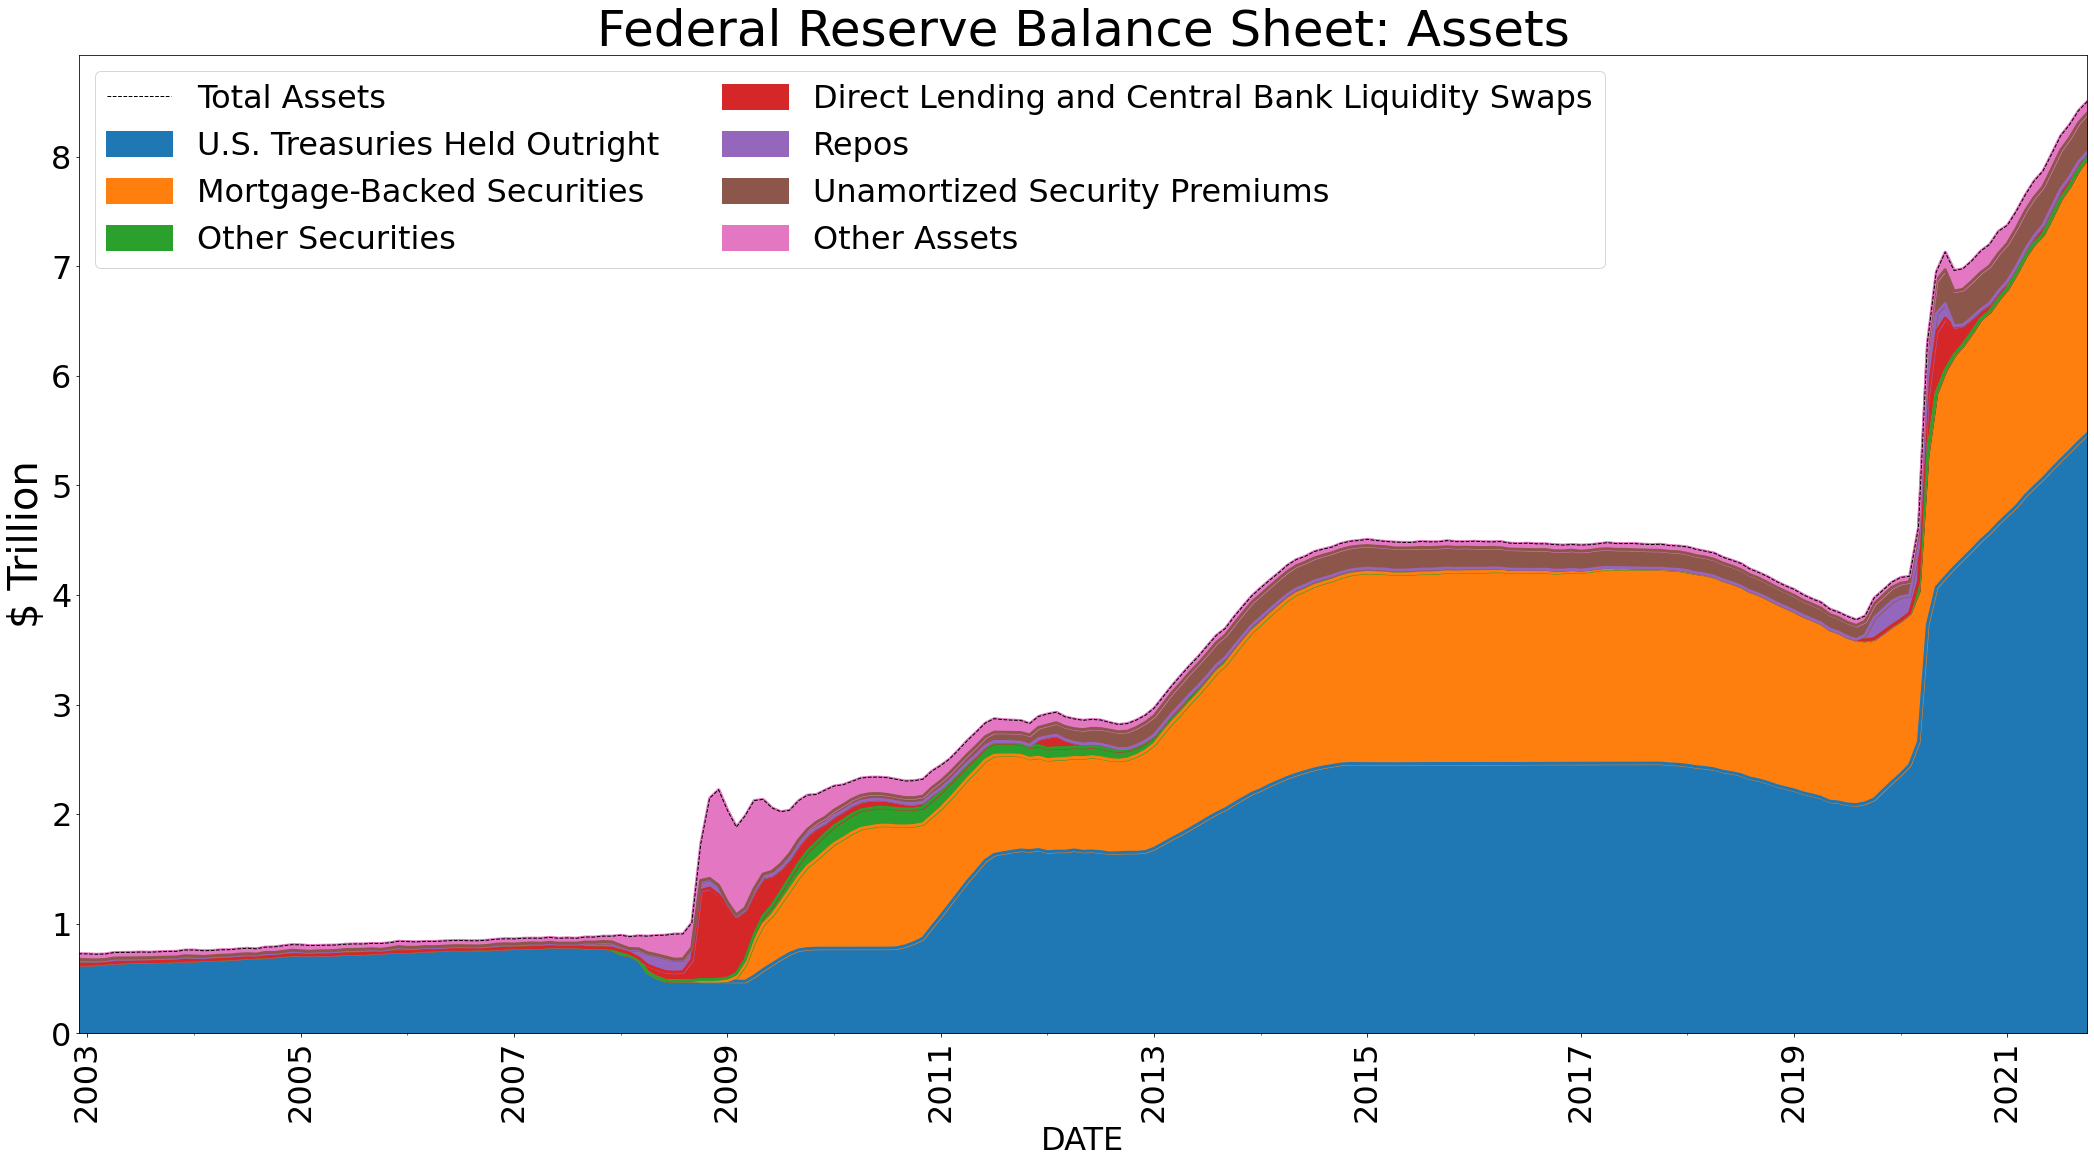

In [8]:
account_vars = ["U.S. Treasuries Held Outright",
               "Mortgage-Backed Securities",
               "Other Securities",
               "Direct Lending and Central Bank Liquidity Swaps",
               "Repos",
               "Unamortized Security Premiums",
               "Other Assets"]
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
# change y vals from mil to tril
total_var = "Total Assets"
plot_data[total_var].plot.line(linewidth = 1, 
                             ax = ax, c = "k",
                             label = total_var, ls = "--")
plt.xticks(rotation = 90)
ax.legend(loc=2, ncol = 2)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Balance Sheet: Assets", fontsize = 50)
plot_data[[total_var] + account_vars].to_csv("FederalReserveAssets.csv")
plot_data[["Date"] + account_vars].to_json("fedAssets.json", orient = "records")

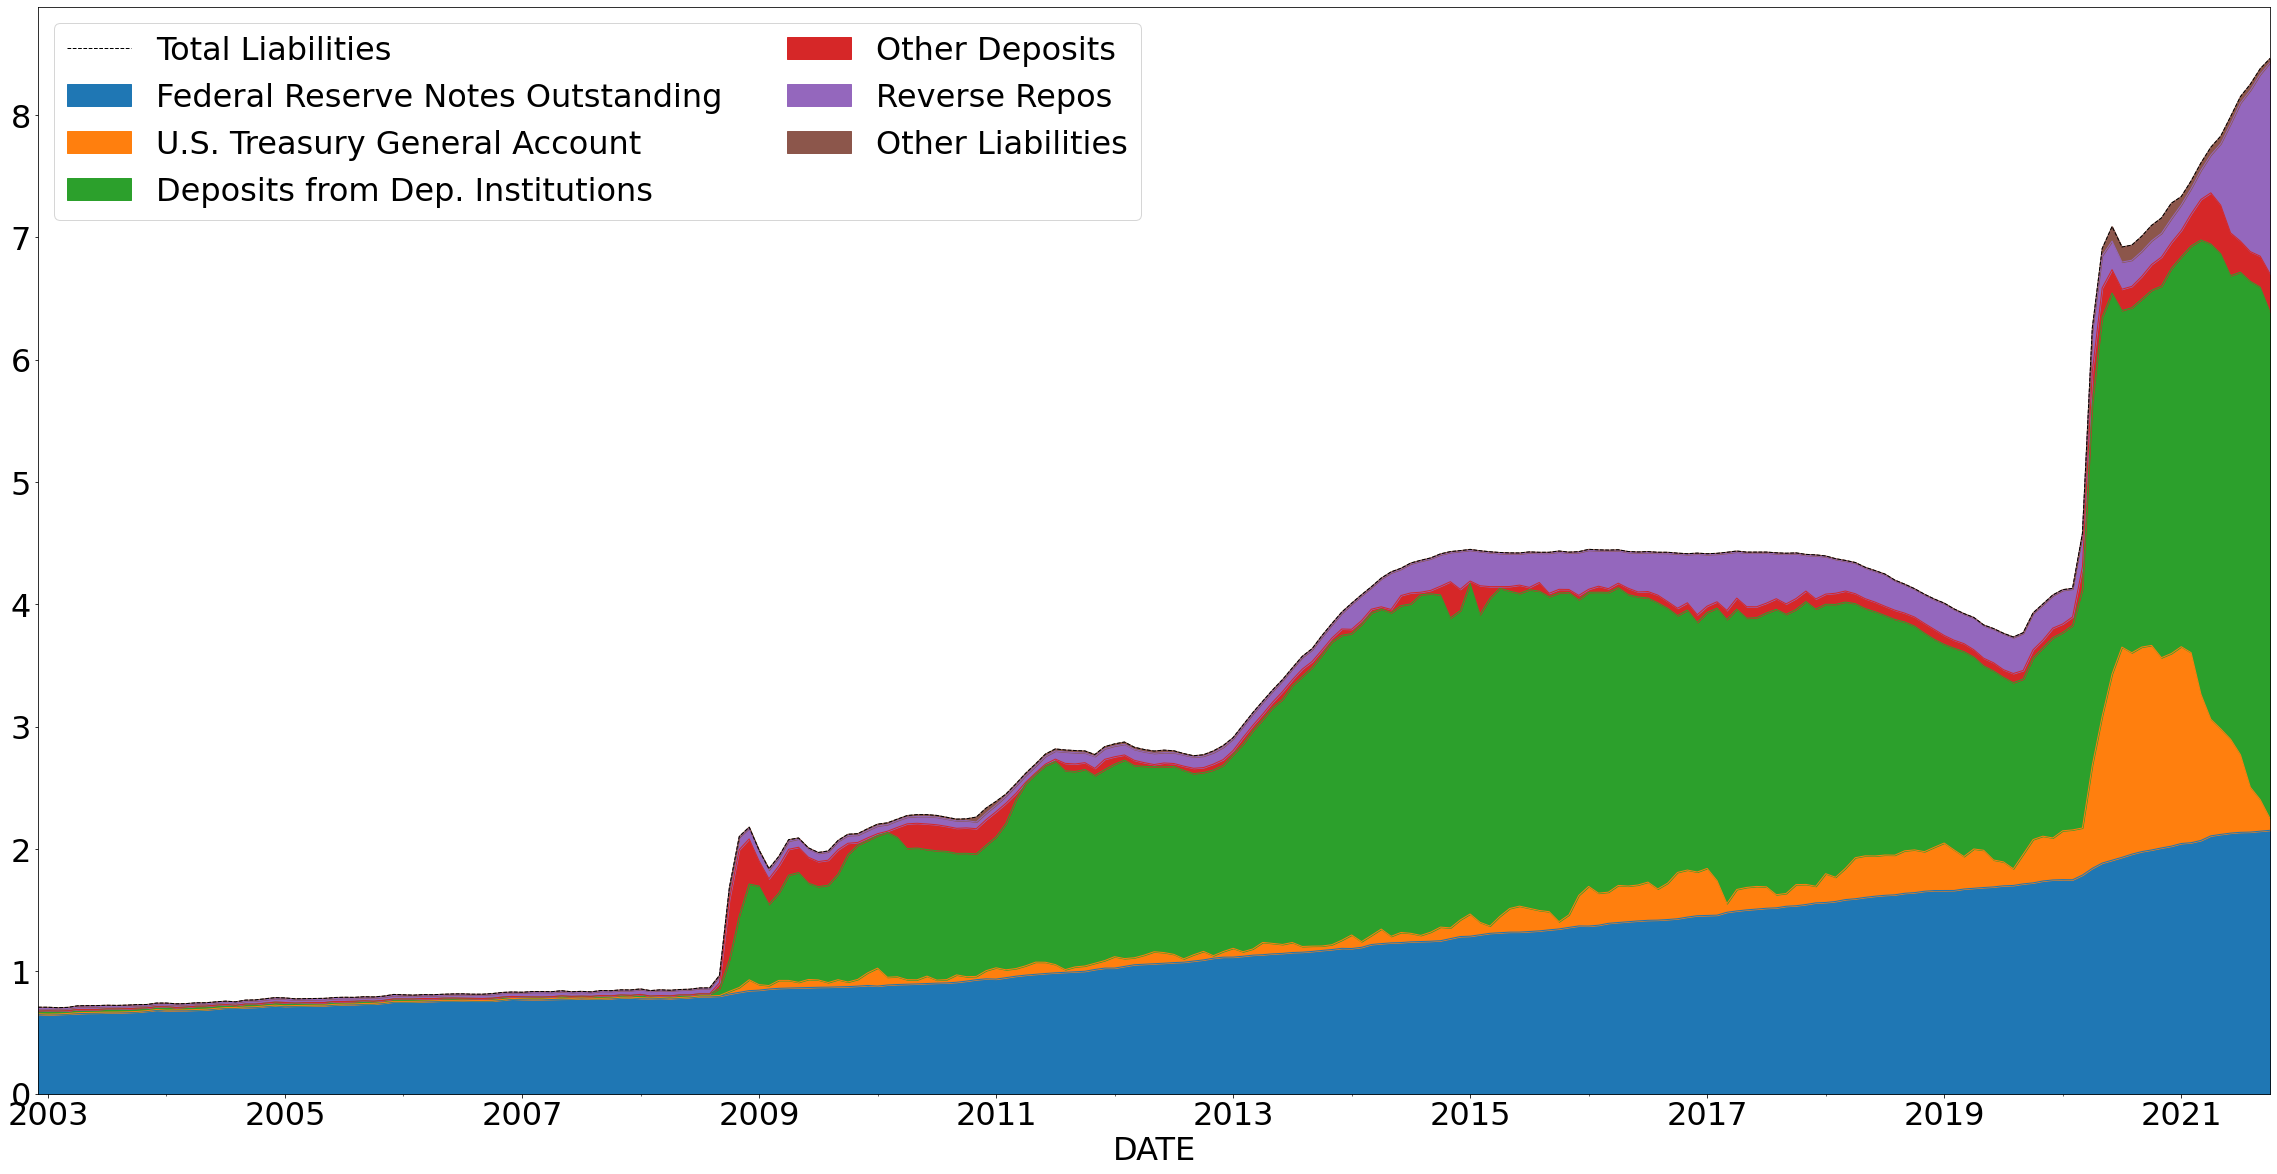

In [9]:
account_vars = ["Federal Reserve Notes Outstanding",
                "U.S. Treasury General Account",
                "Deposits from Dep. Institutions",
                "Other Deposits",
                "Reverse Repos",
                "Other Liabilities"]
total_var = "Total Liabilities"

plot_stacked_lines(
    plot_data,
    account_vars, linewidth = 1,
    total_var = "Total Liabilities")


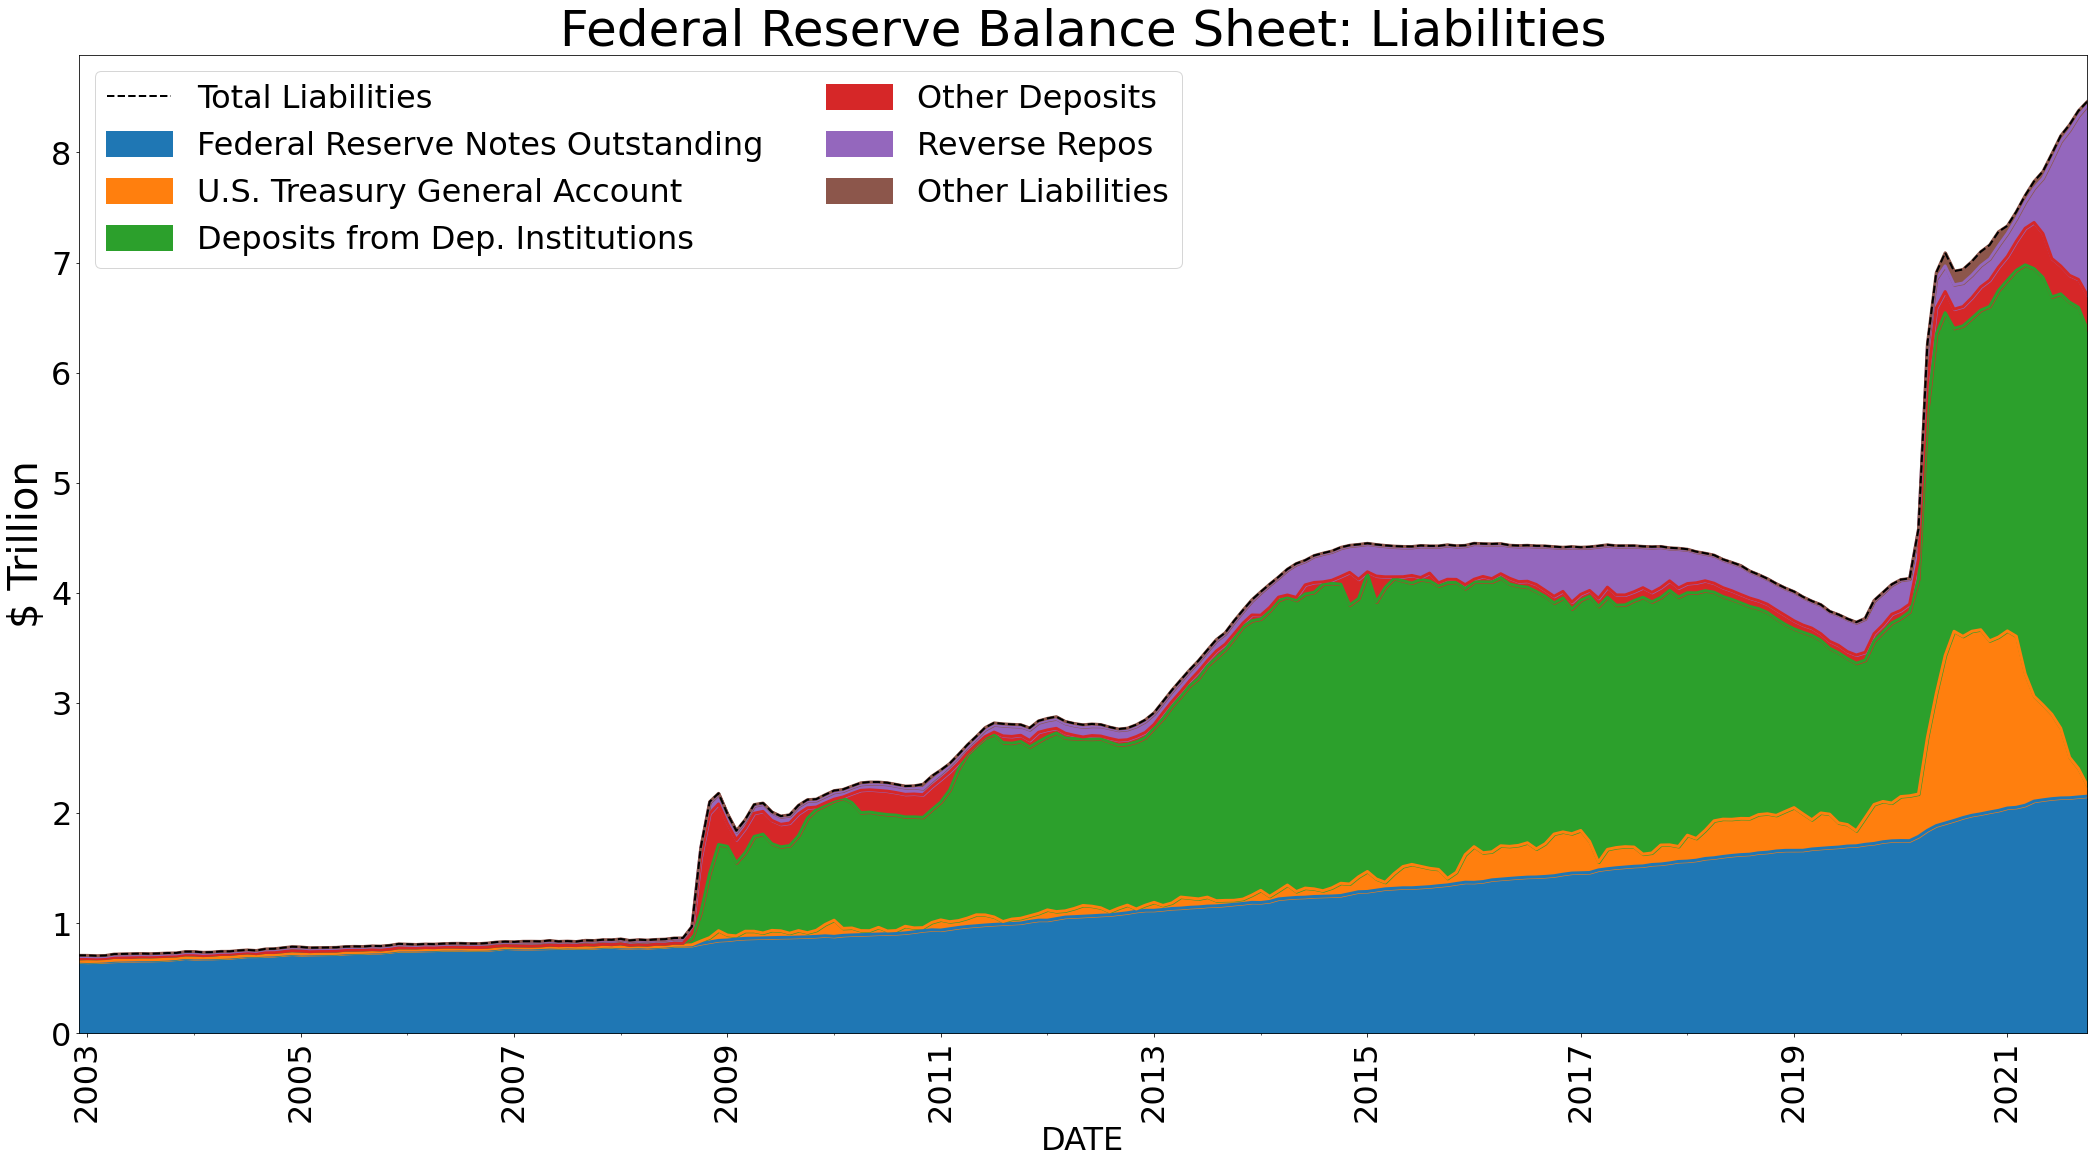

In [10]:
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
# change y vals from mil to tril
total_var = "Total Liabilities"
plot_data[total_var].plot.line(linewidth = 2, 
                             ax = ax, c = "k",
                             label = total_var, ls = "--")
plt.xticks(rotation = 90)
ax.legend(loc=2, ncol = 2)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Balance Sheet: Liabilities", fontsize = 50)
plot_data[[total_var] + account_vars].to_csv("FederalReserveLiabilities.csv")

<ipython-input-11-bd89c59b9c46>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)


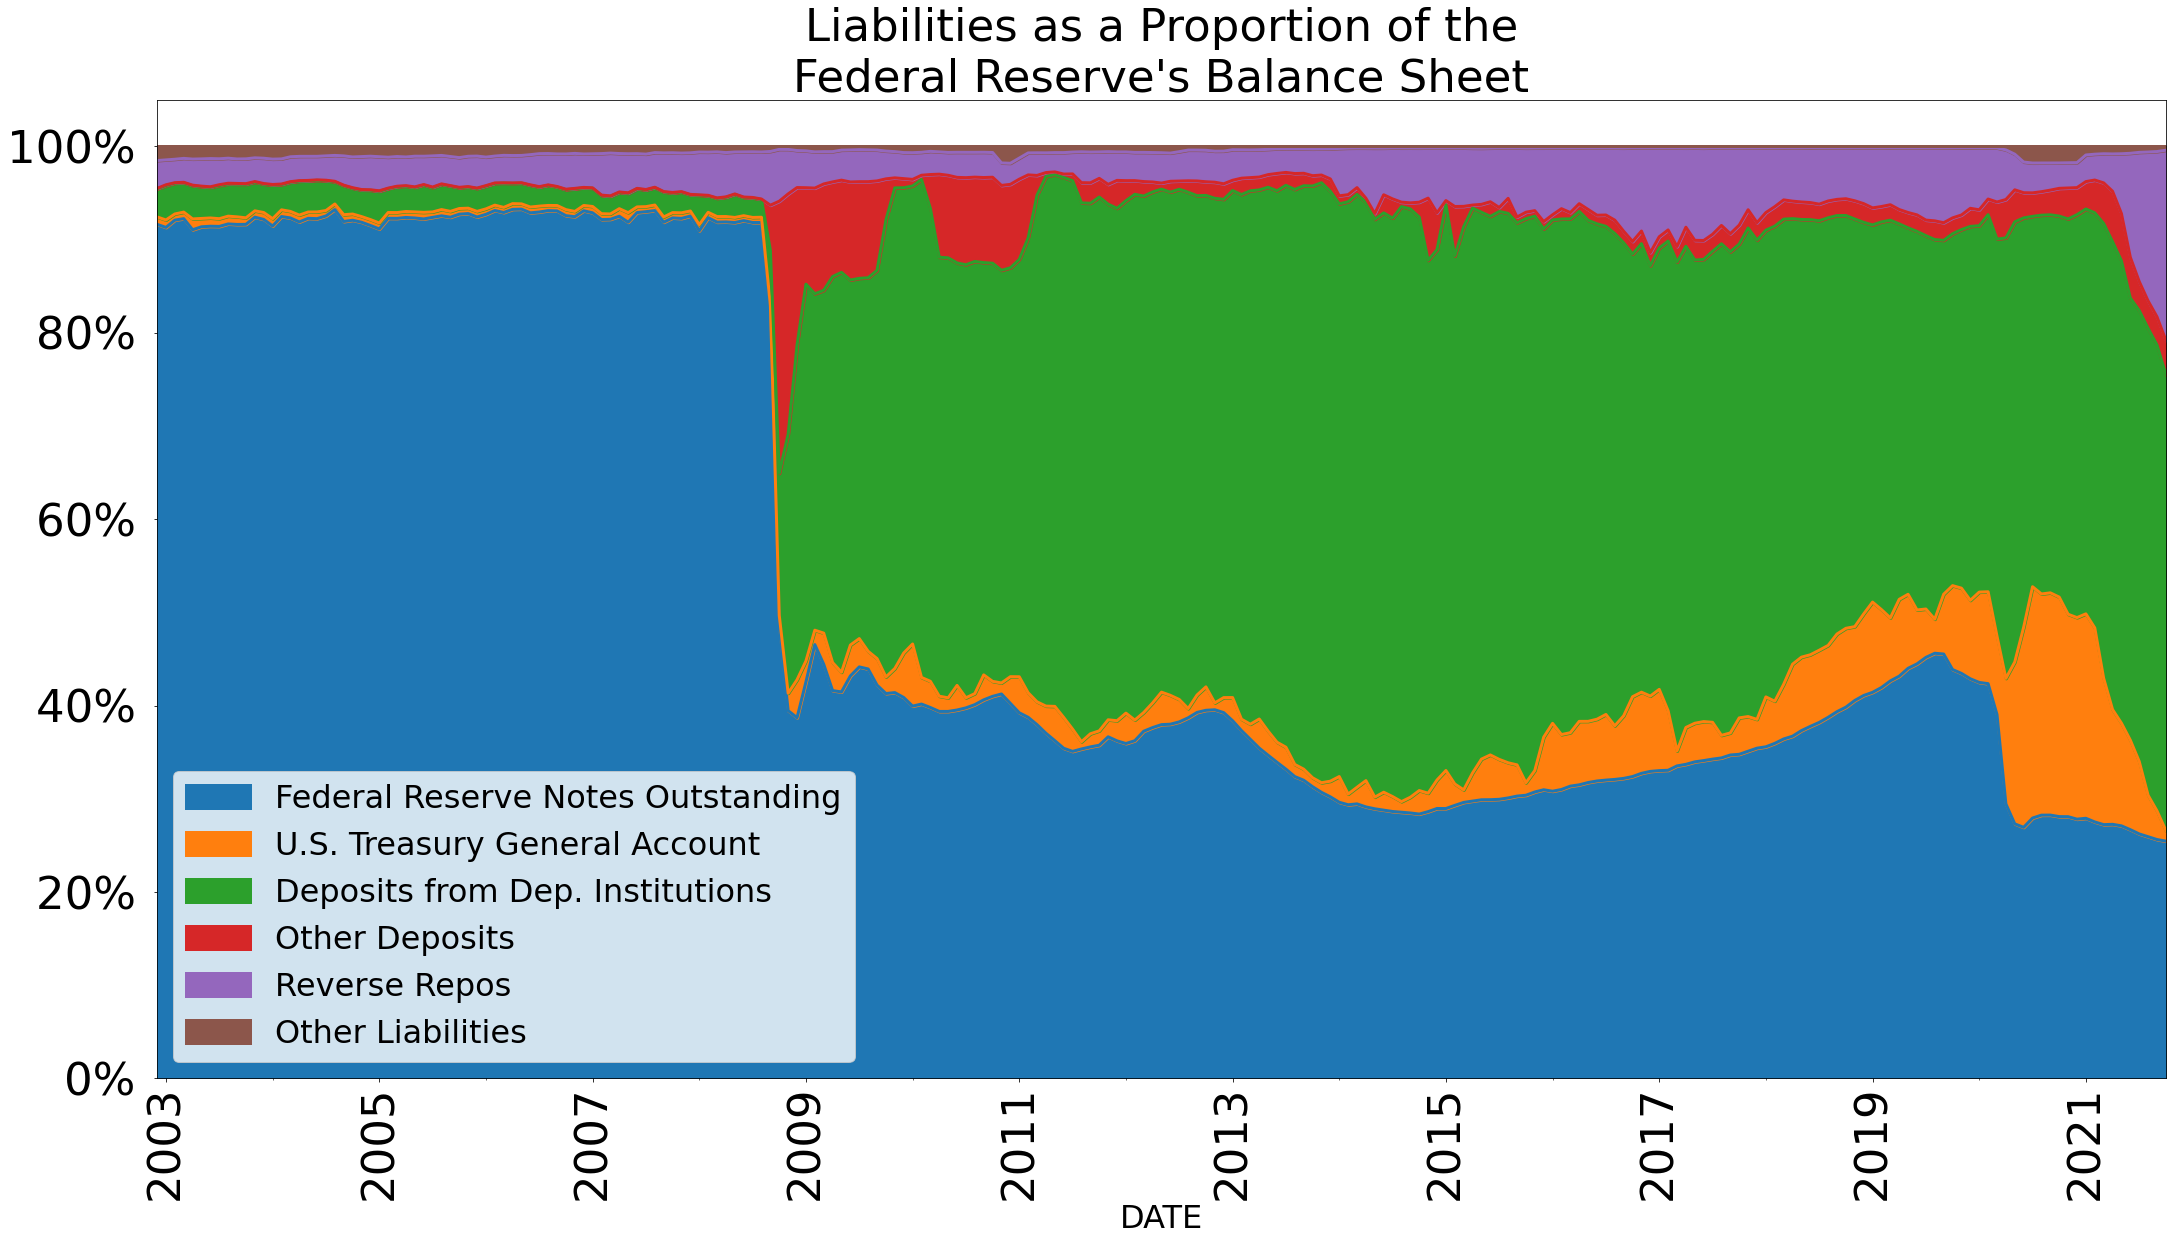

In [11]:
plt.rcParams.update({"font.size":32})
df = plot_data.copy()
for key in account_vars:
    df[key] = df[key].div(df["Total Liabilities"])
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
df[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
plt.xticks(rotation= 90, fontsize = 45)
ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)

#plt.yticks([int(tick * 100) for tick in ax.get_yticks() if tick <1.01])
plt.title("Liabilities as a Proportion of the\nFederal Reserve's Balance Sheet", fontsize =45)
plt.show()


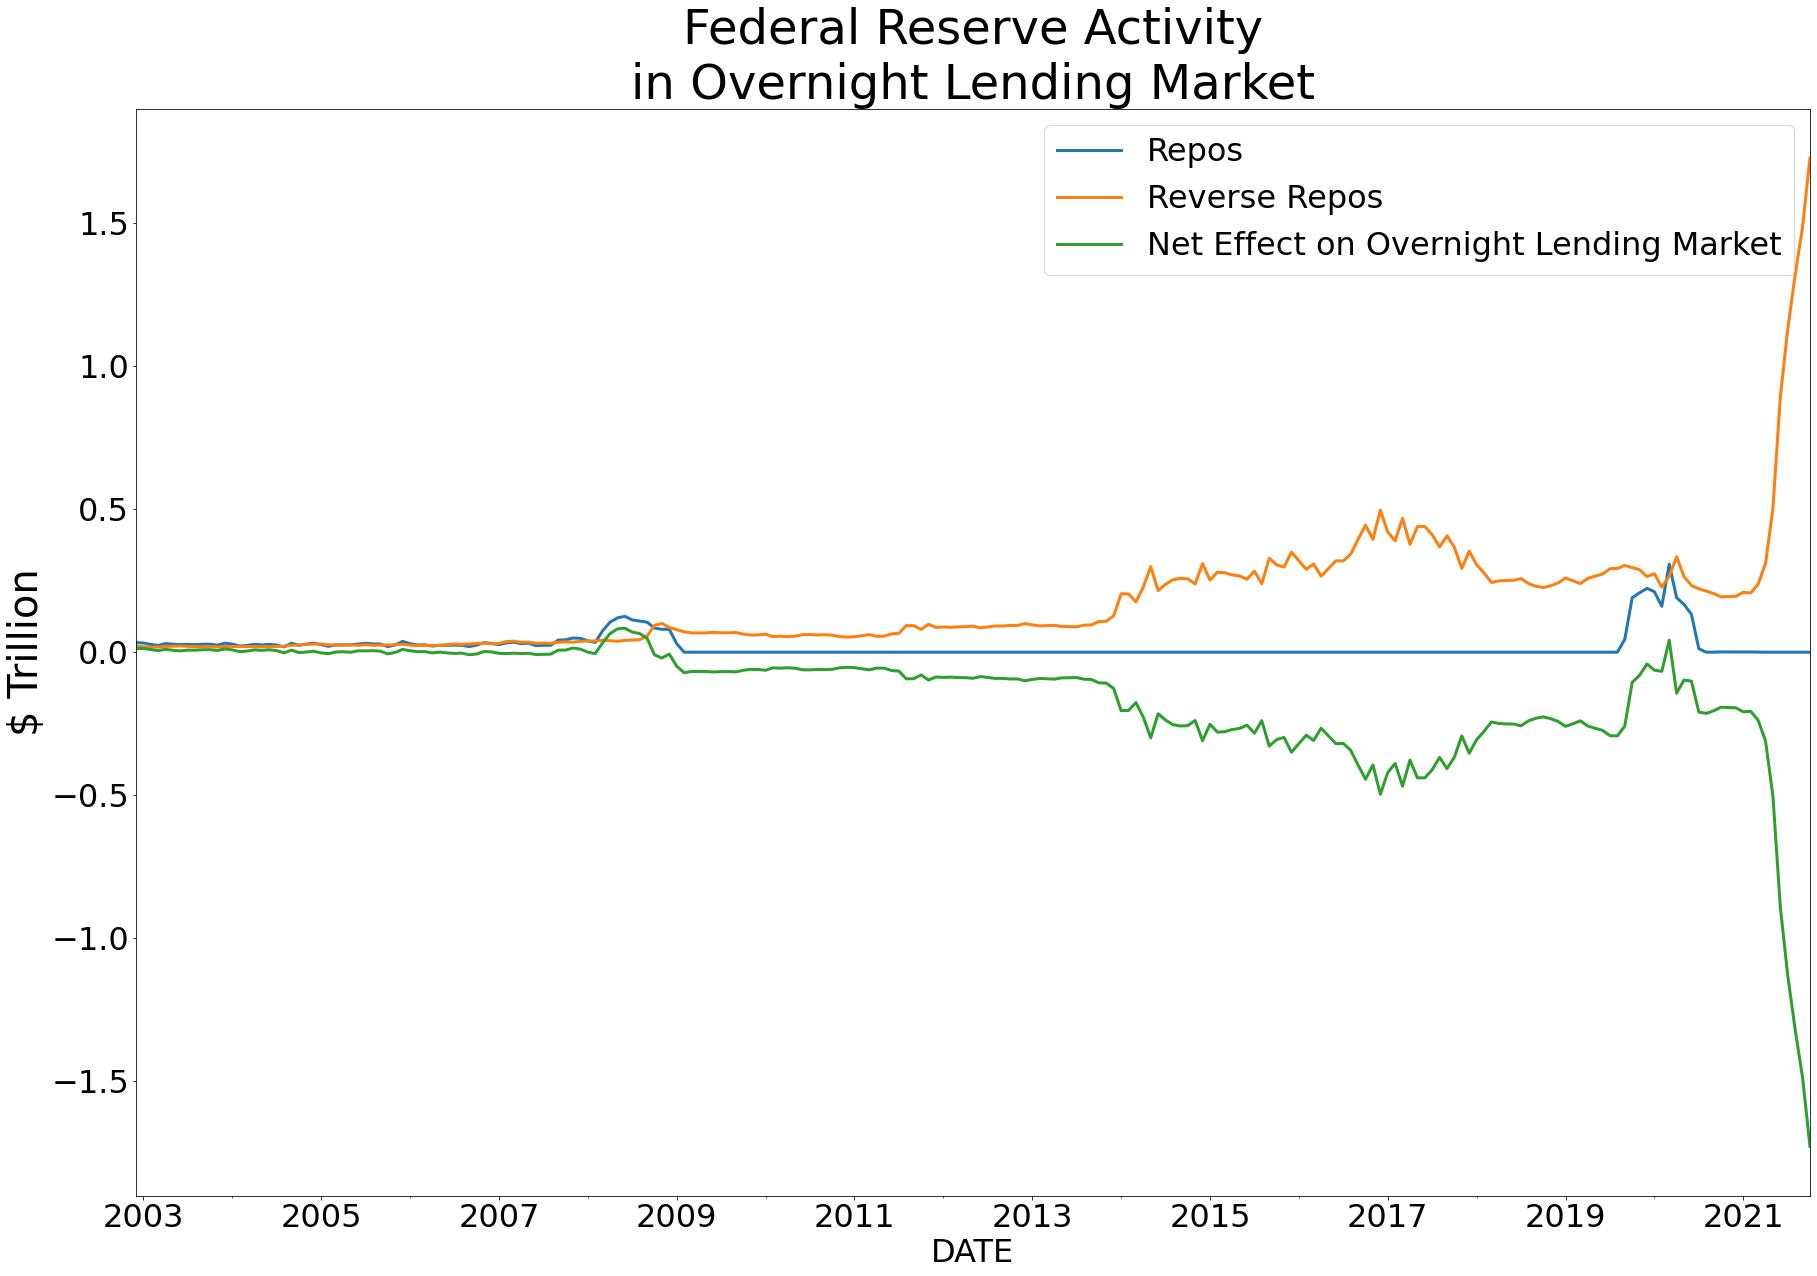

In [12]:
overnight_vars = ["Repos",
                  "Reverse Repos",
                  "Net Effect on Overnight Lending Market"]
fig, ax = plt.subplots(figsize = (30,20))
plot_data[overnight_vars].plot.line(legend=True, linewidth = 3, ax = ax)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Activity\nin Overnight Lending Market", fontsize = 48)
plot_data[["Date"] + overnight_vars].to_json("overnightLending.json", orient="records")


<ipython-input-13-0eb8385d5df6>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val )) + "%" for val in ax.get_yticks()], c = "C0")
<ipython-input-13-0eb8385d5df6>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([str(int(val)) + "%" for val in ax2.get_yticks()], c = "C1")
<ipython-input-13-0eb8385d5df6>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(ax3.get_yticks(), alpha = .2, c = "k")


Text(2021-09-01 00:00:00, 93.5, '0 ')

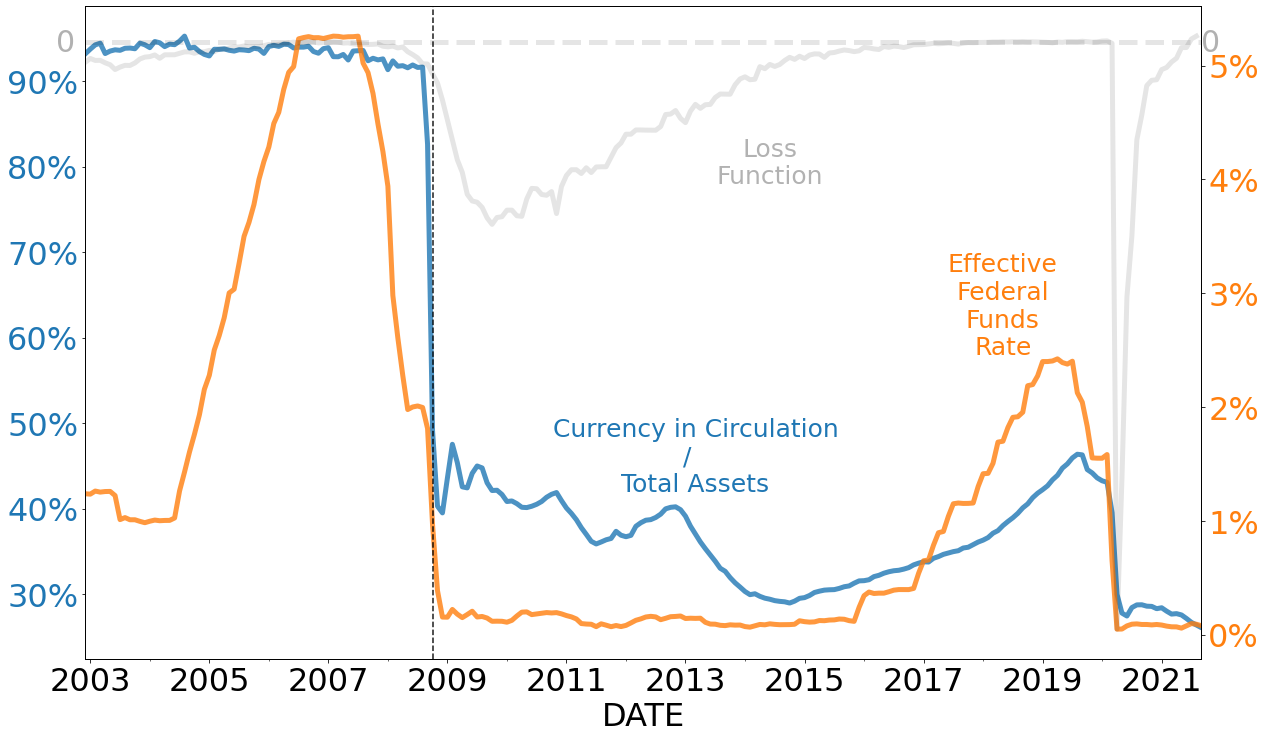

In [13]:
figsize = (20,12)
fig,ax = plt.subplots(figsize = figsize)

ax2 = ax.twinx()
ax3 = ax.twinx()
data[["Currency in Circulation / Total Assets"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax)
data[["Effective Federal Funds Rate (%)"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax2,
                                                        c = "C1")
data[["Loss Function"]].iloc[:-1].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .1,
                                                      ax = ax3,
                                                        c = "k")

ax.set_yticklabels([str(int(val )) + "%" for val in ax.get_yticks()], c = "C0")
ax2.set_yticklabels([str(int(val)) + "%" for val in ax2.get_yticks()], c = "C1")
ax3.set_yticklabels(ax3.get_yticks(), alpha = .2, c = "k")
ax3.set_yticks([])

ax3.axhline(0, c = "k", alpha = .1, linewidth = 5, ls = "--")

plt.axvline(datetime.datetime(2008,10,1), c = "k", ls = "--", alpha = .9)
ax.text(datetime.datetime(2013,3,1), 42, "Currency in Circulation\n/  \nTotal Assets", fontsize = 25, c = "C0", 
        ha = "center")
ax.text(datetime.datetime(2018,5,1), 58, "Effective\nFederal\nFunds\nRate", fontsize = 25, c = "C1", 
        ha = "center")
ax.text(datetime.datetime(2014,6,1), 78, "Loss\nFunction", fontsize = 25, c = "k", alpha = .3, 
        ha = "center")
ax.text(datetime.datetime(2002,10,10), 93.5, "0", fontsize = 30, c = "k", alpha = .3, 
        ha = "right")
ax.text(datetime.datetime(2021,9,1), 93.5, "0 ", fontsize = 30, c = "k", alpha = .3, 
        ha = "left")

In [14]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import copy
import pingouin
from scipy.stats import pearsonr
from datlib.ts_tests import *

In [15]:
p_val = .05
rename_dct = {"Effective":"FFR",
             "Circulation / Total":"C/A",
              "Circulation Growth":"C",
             "Assets Growth":"A",
              "Function":"LF",
              
             "Inflation":"$\pi$",
             "Unemployment":"U"}

# indicate whether or not to include a constant and time trend for each regression
diffs = {"":"ct", " Diff":"c", " Diff-in-Diff":"nc"}

adf_dct = {}
for diff in diffs:
    # test all variables, include loss fucntion components
    plot_vars_dct = {"Augmented Dickey Fuller": [
        "Effective Federal Funds Rate" +diff + " (%)",
        "Currency in Circulation / Total Assets" + diff,
        "Loss Function" + diff,
        "Unemployment Loss" + diff,
        "Inflation Loss" + diff]}
    adf_dct[diff]={}
    for i in plot_vars_dct:
        # include full range of dates
        var_data = data[plot_vars_dct[i]].dropna()
        data[plot_vars_dct[i]].describe().T.to_csv(diff + "SummaryStats.csv")
        for key in var_data:
            for rename_key in rename_dct:
                if rename_key in key:
                    dif = diff if "Diff" in key else""
                    lag = " Lag" if "Lag" in key else ""
                    var_data.rename(columns={key:rename_dct[rename_key]+dif + lag}, inplace = True)
        var_data.dropna(inplace = True)
        # due to small n for annual frequency, the relevant subsets are not tested
        var_data = var_data#.loc["2009":"2020-02-29"]#.plot(figsize = (14,8))
        adf_dct[diff][i] = {}
        for j in range(0,year):
            constant_time_trend = diffs[diff]
            adfuller_stats = adfuller_df(var_data.iloc[j::year],  
                                         maxlag = int(round(12 / year, 0)), regression = constant_time_trend) 
            adf_dct[diff][i][j]=adfuller_stats
        adf_dct[diff][i] = pd.DataFrame(adf_dct[diff][i]).T
        adf_dct[diff][i].rename(index={0:year}, inplace = True)
        adf_dct[diff][i].sort_index(inplace = True)
        adf_dct[diff][i].index.name= "Month"

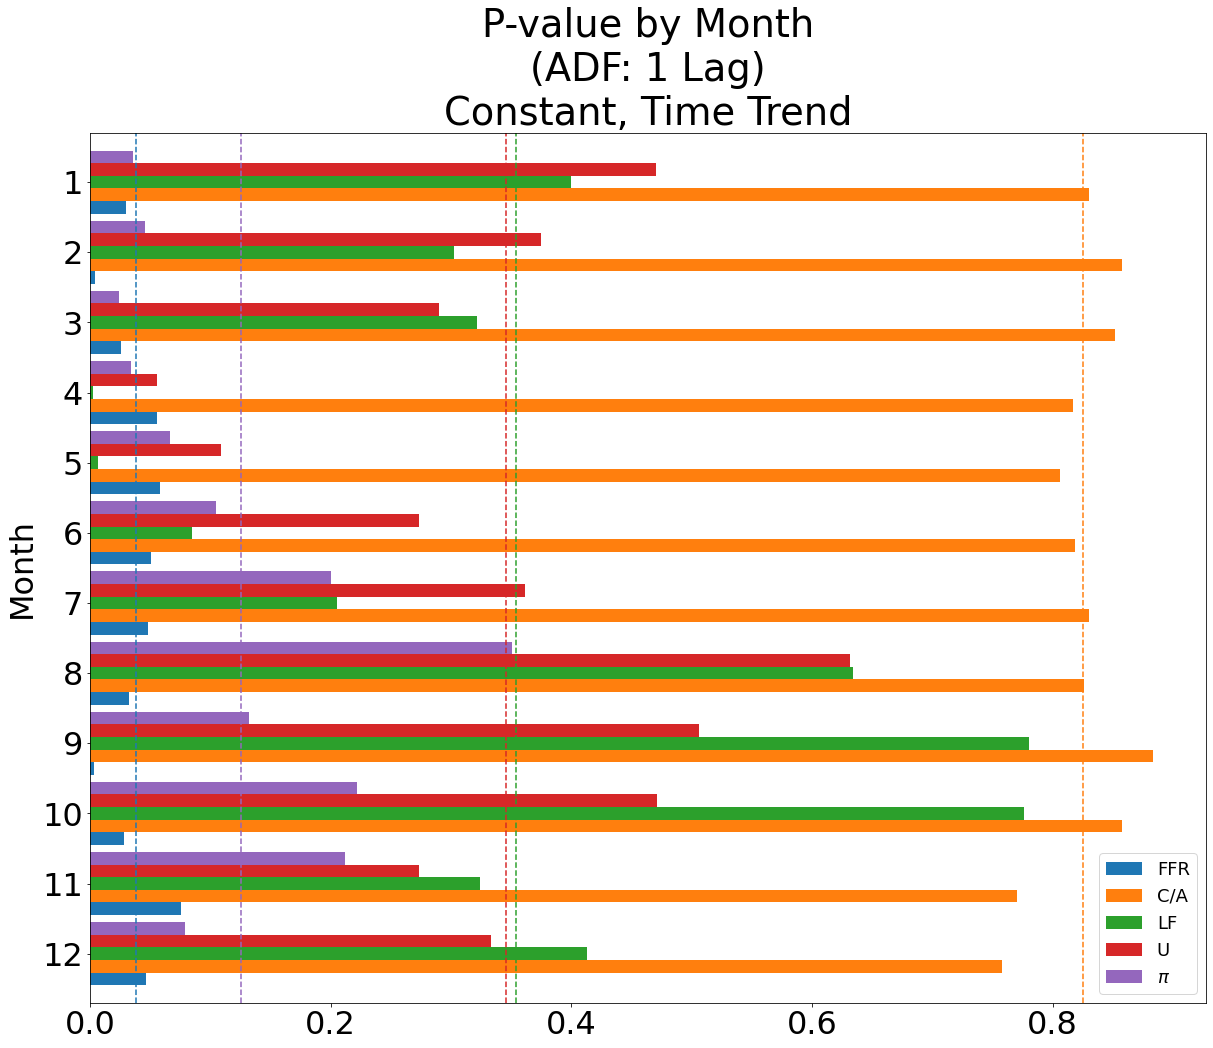

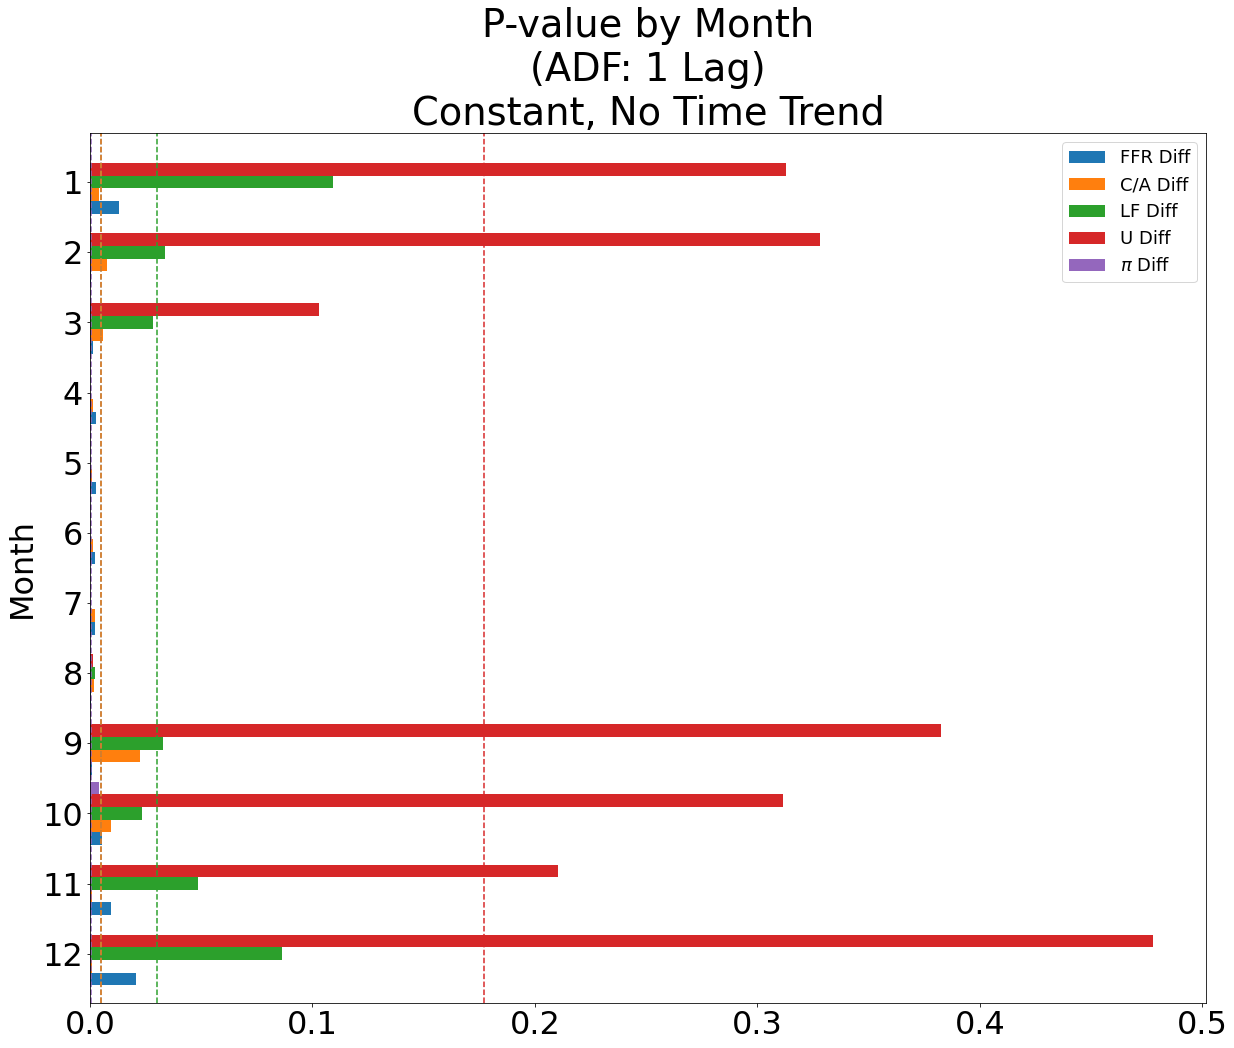

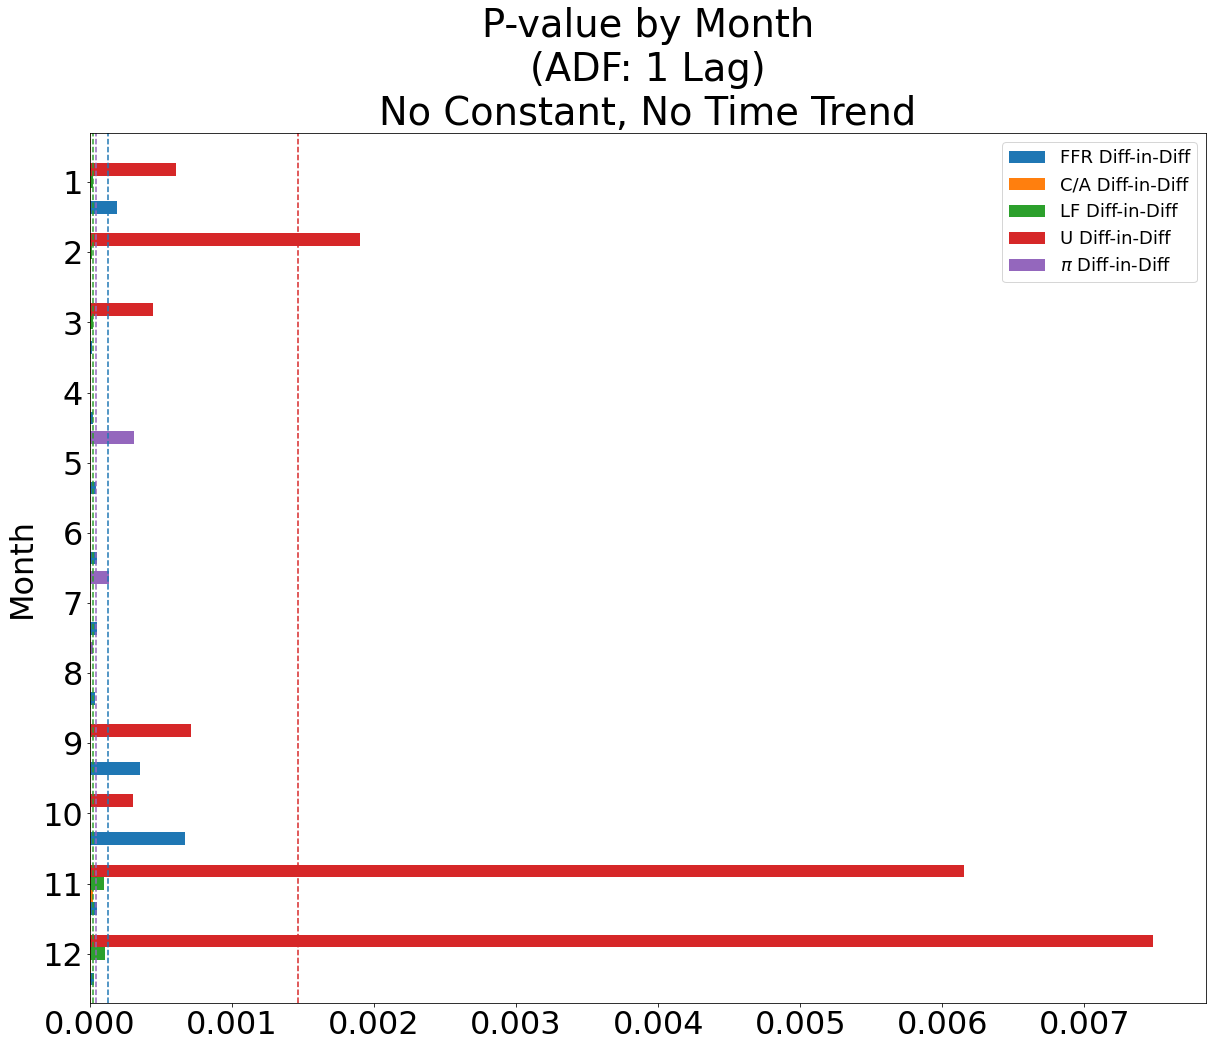

In [16]:
for diff in adf_dct:
    for var_list, df in adf_dct[diff].items():
        fig,ax = plt.subplots(figsize = (20,16))
        df.sort_index(ascending=False).plot.barh(legend = False, width =.9, ax=ax)
        plt.legend(fontsize = 18)
        title = "P-value by Month\n(ADF: "+str(int(round(12/year,0)))+" Lag)"
        constant_time_trend = diffs[diff]
        if diff == "":
            title = title + "\n" + "Constant, Time Trend"
        elif diff == " Diff":
            title = title + "\n" + "Constant, No Time Trend"
        elif diff == " Diff-in-Diff":
            title = title + "\n" + "No Constant, No Time Trend"

        plt.title(title)

        mean_vals = df.sort_index(ascending=False).mean()
        for i in range(len(mean_vals)):
            val = mean_vals[i]
            ax.axvline(val, color = "C" + str(i), ls = "--")
    

C:\Users\JLCat\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-17-b8feaa5ae666>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[new_key] = var_data[key].shift(year * i)
<ipython-input-17-b8feaa5ae666>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_data.dropna(inplace=True)
Wor

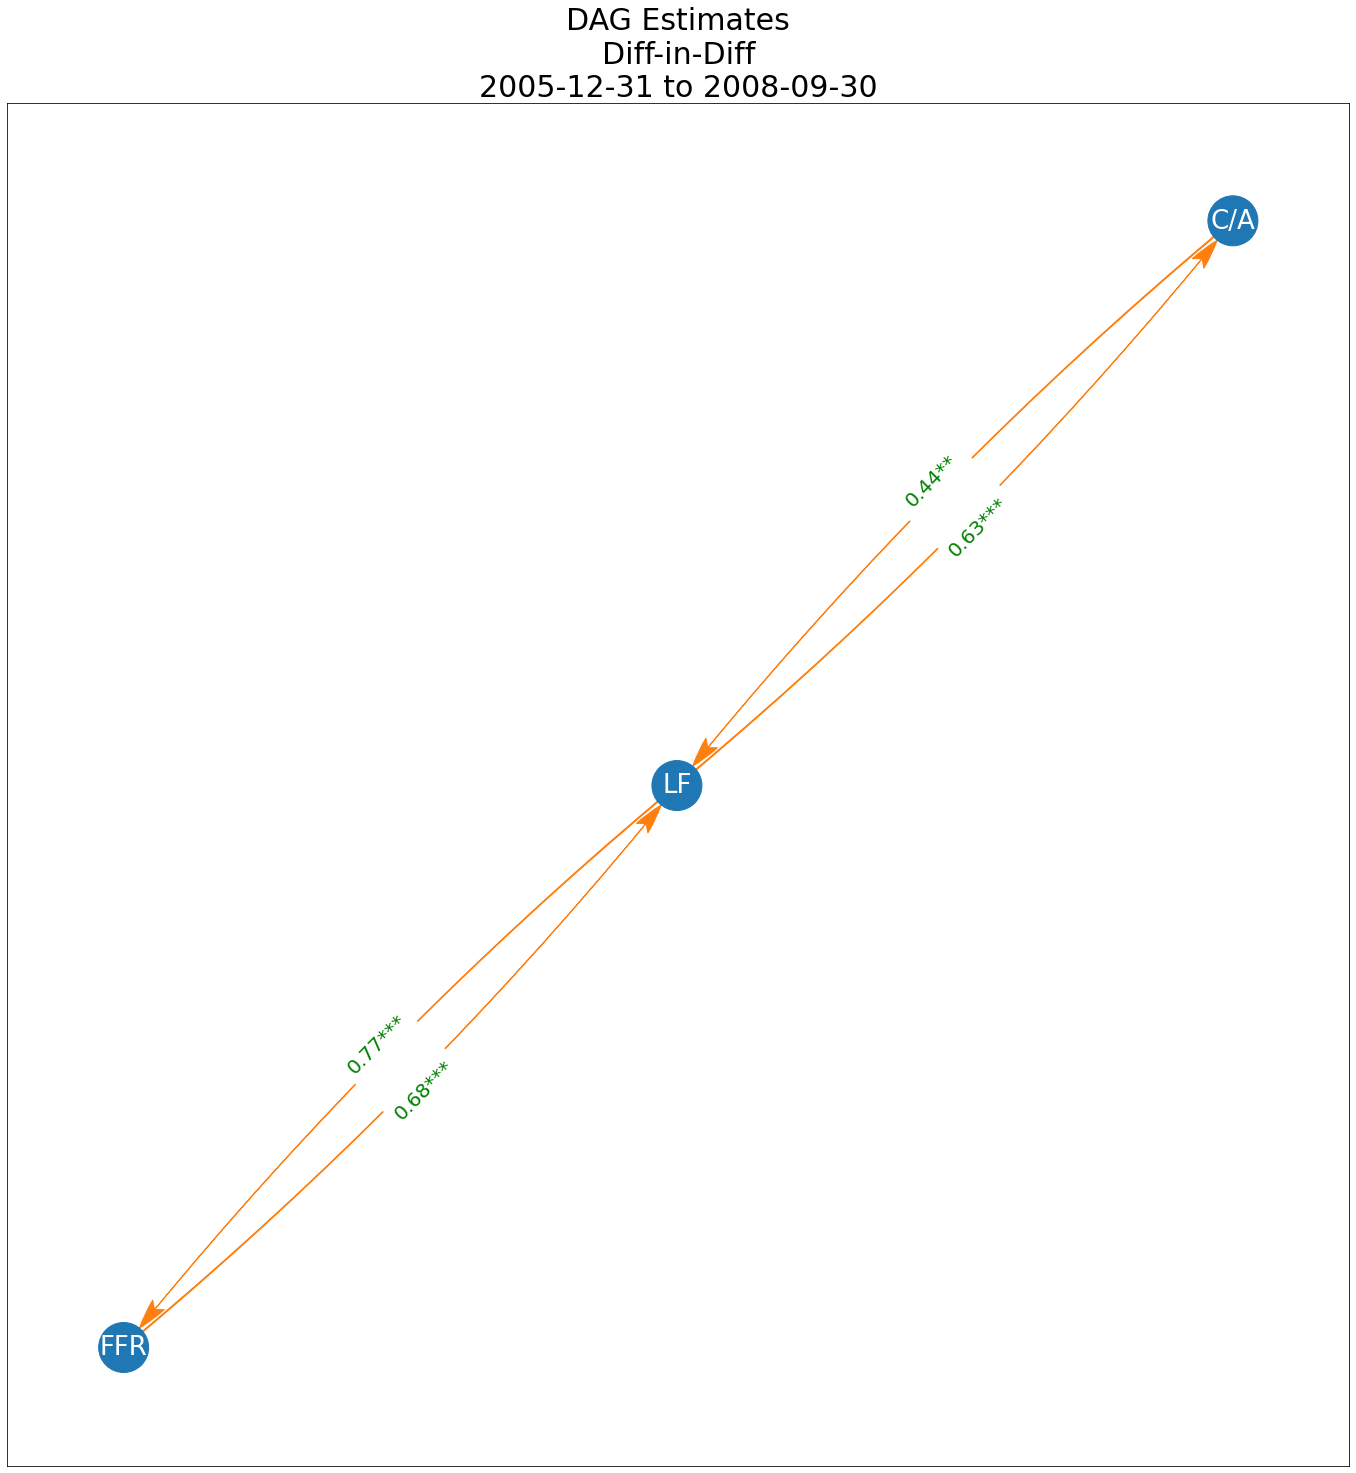

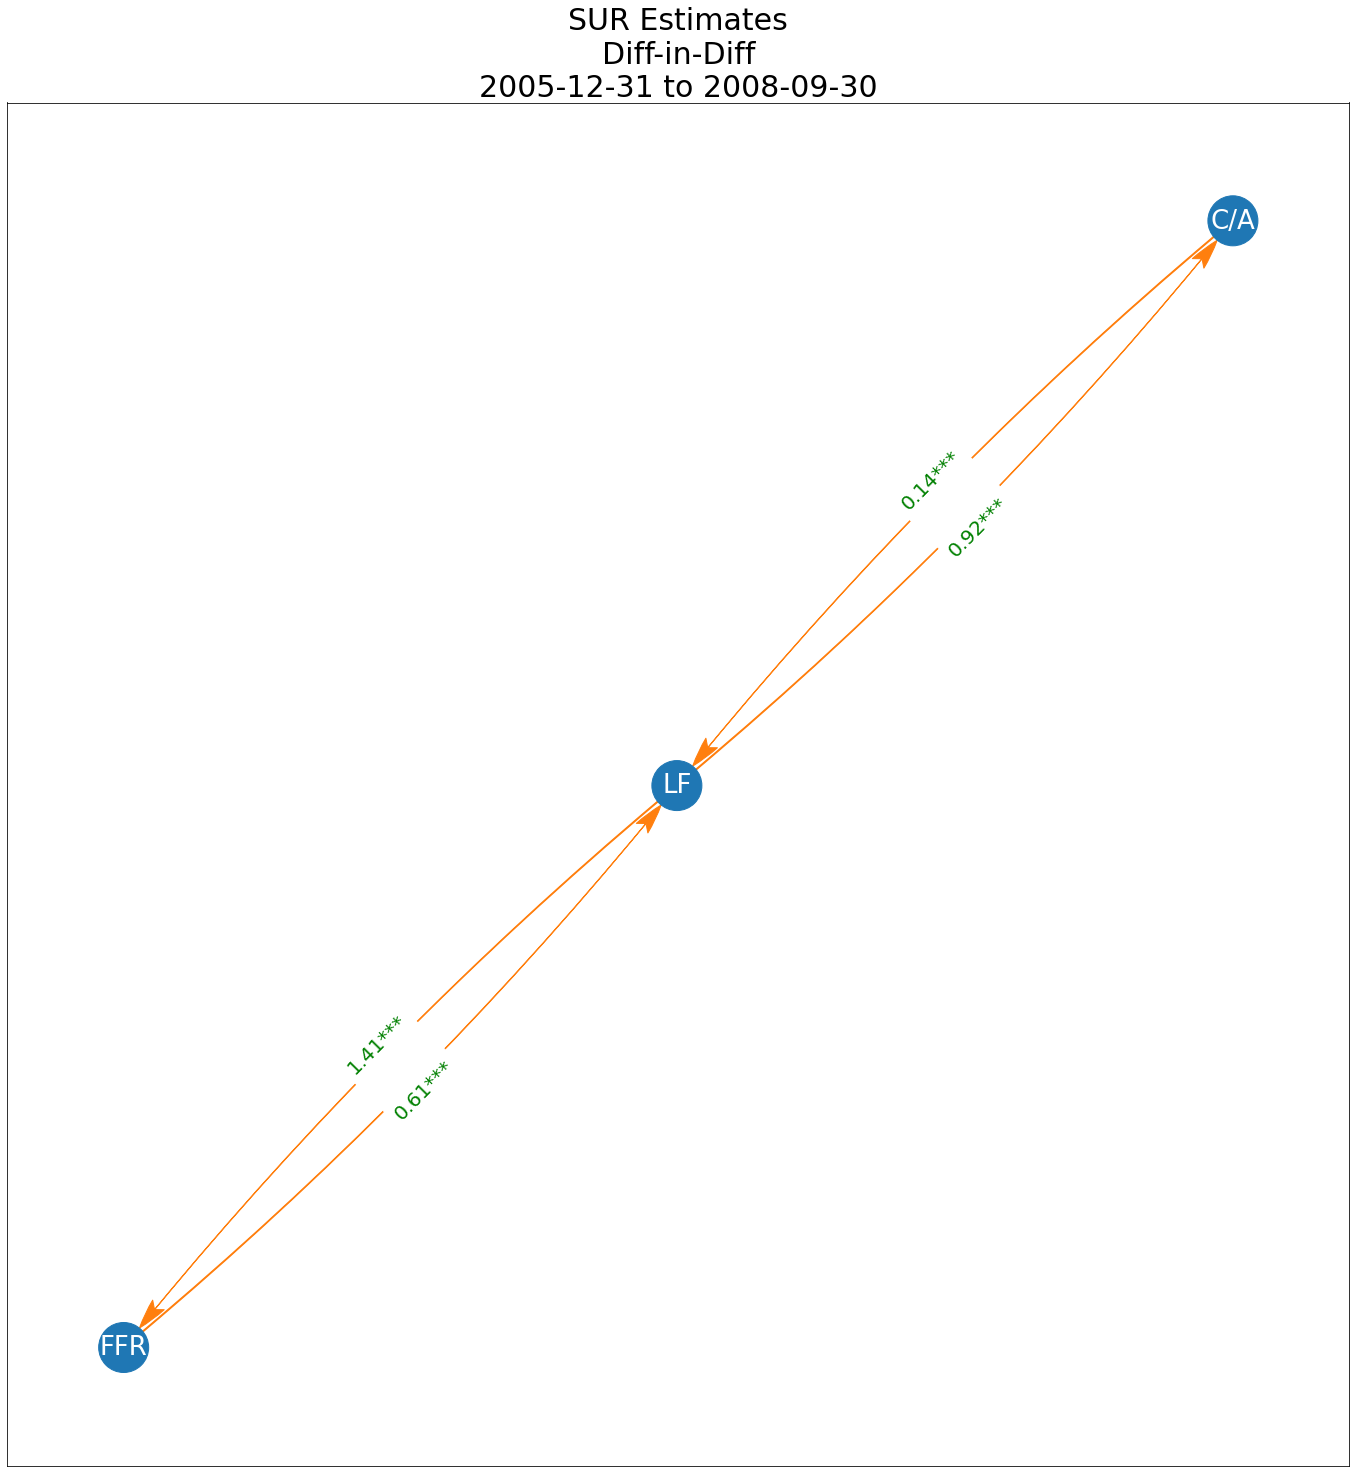

C:\Users\JLCat\GithubRepositories\ProjectRepositories\MappingTheFederalReserve'sResponseFunctionWithDirectedAcyclicGraphs\datlib\DAG.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_data.dropna(inplace = True)
C:\Users\JLCat\GithubRepositories\ProjectRepositories\MappingTheFederalReserve'sResponseFunctionWithDirectedAcyclicGraphs\datlib\DAG.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_data.dropna(inplace = True)


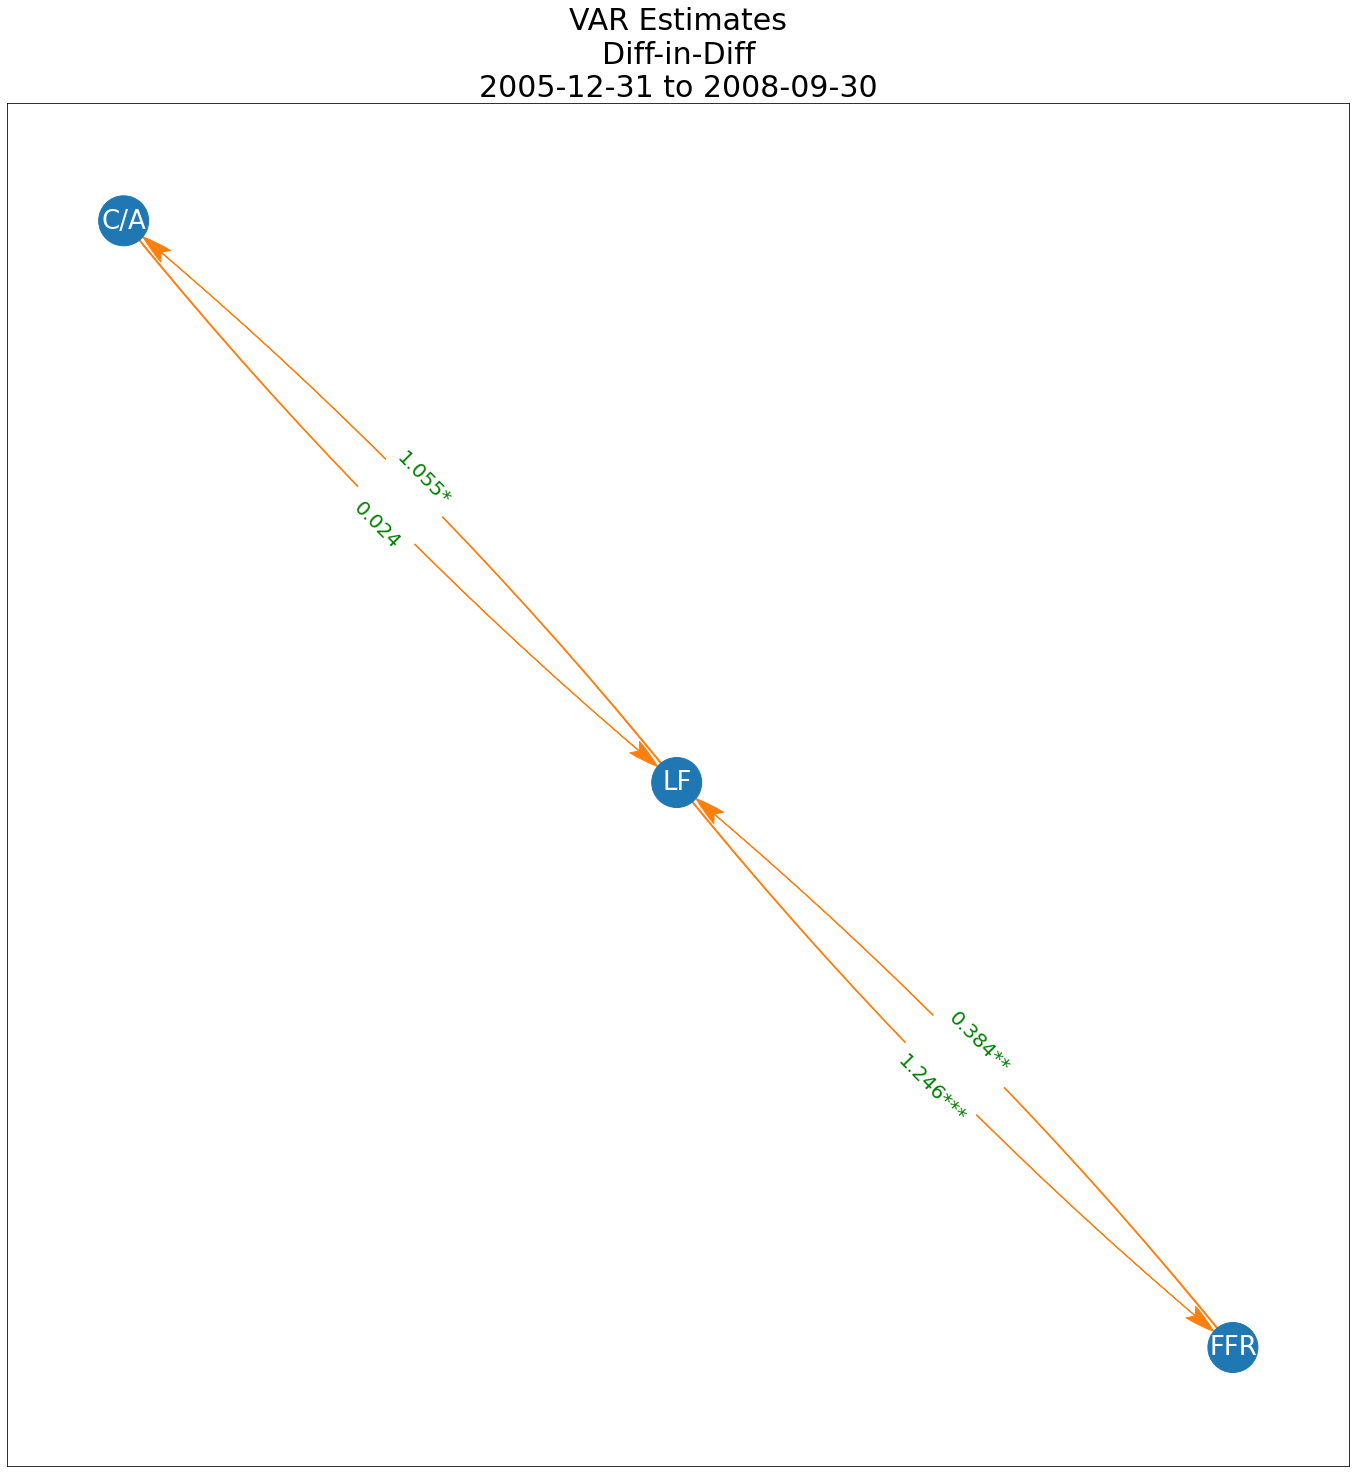

Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]

LF
Sink         C/A       FFR       LF
Source                             
C/A Lag  -0.48**    -0.074    0.024
FFR Lag  0.664**  0.673***  0.384**
LF Lag    0.875*  1.303***  0.818**

FFR
Sink          FFR        LF
Source                     
FFR Lag   0.68***   0.382**
LF Lag   1.246***  0.837***

C/A
Sink          C/A       LF
Source                    
C/A Lag  -0.546**   -0.014
LF Lag     1.055*  0.922**



C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 12.85it/s]


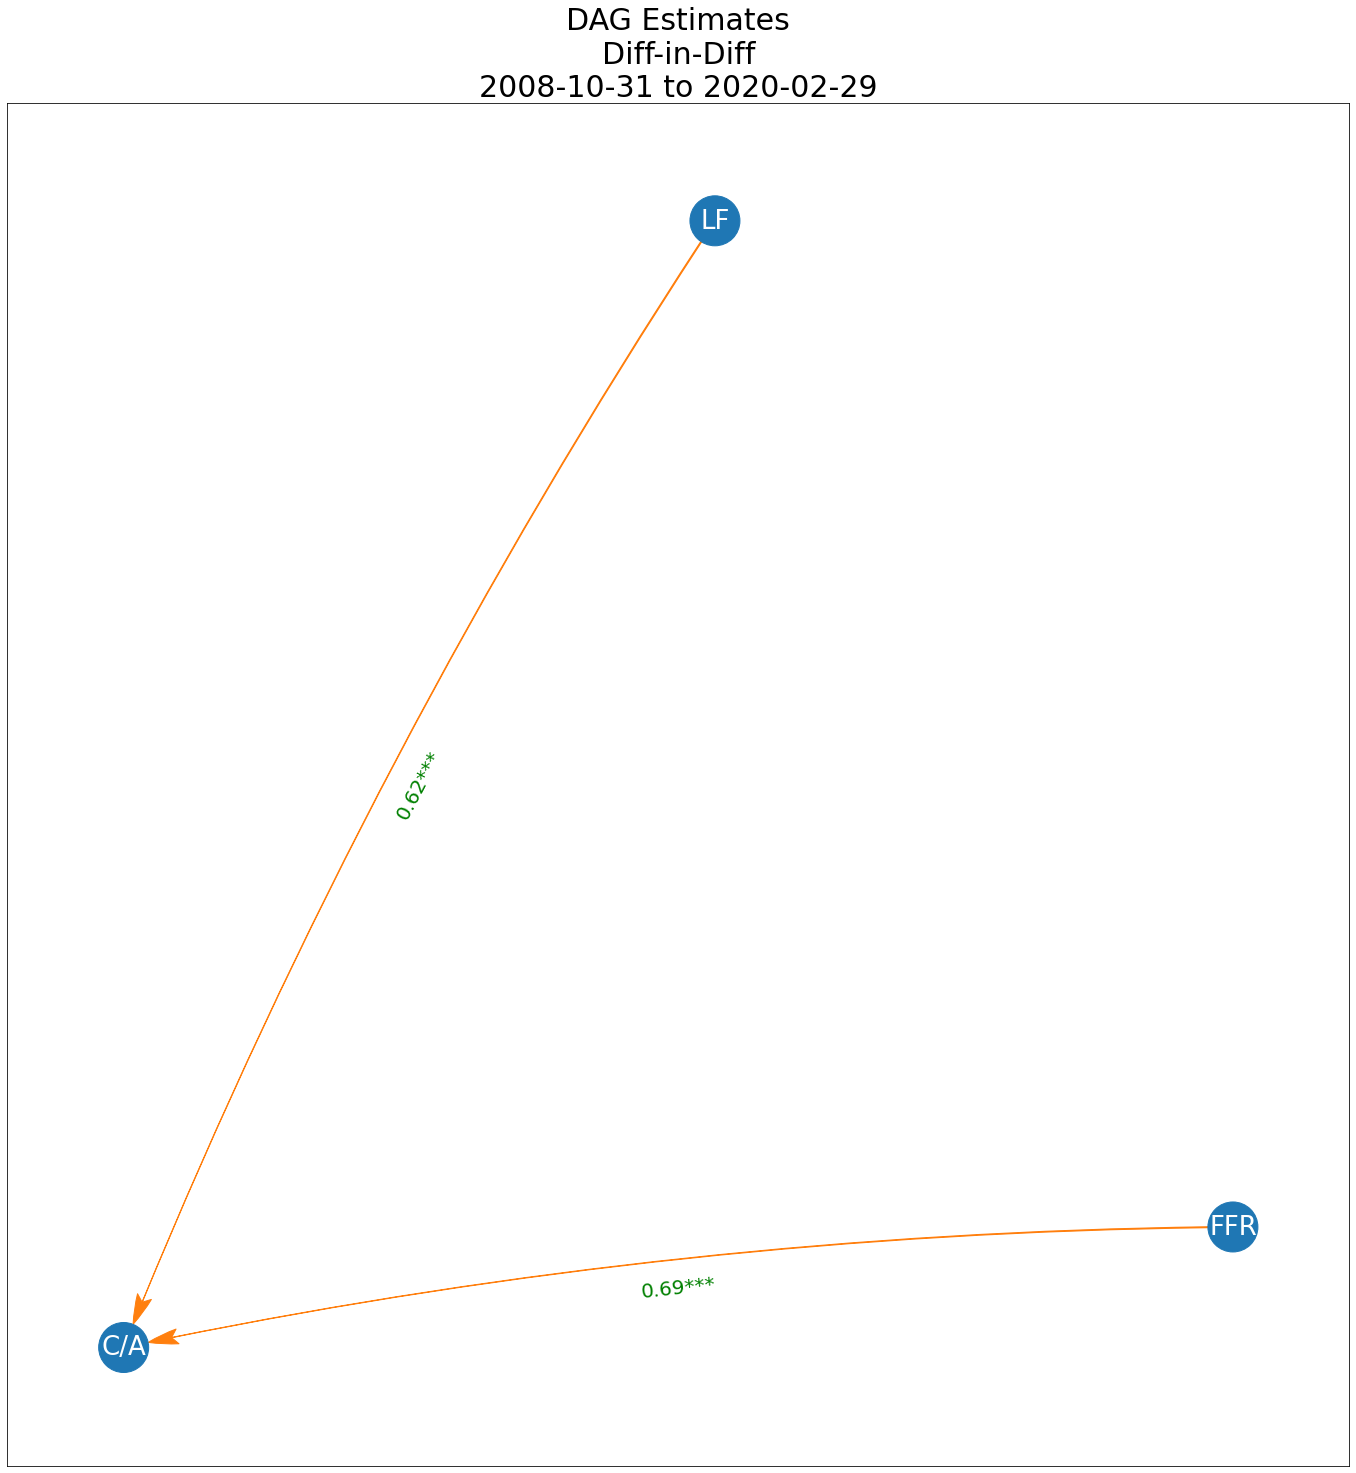

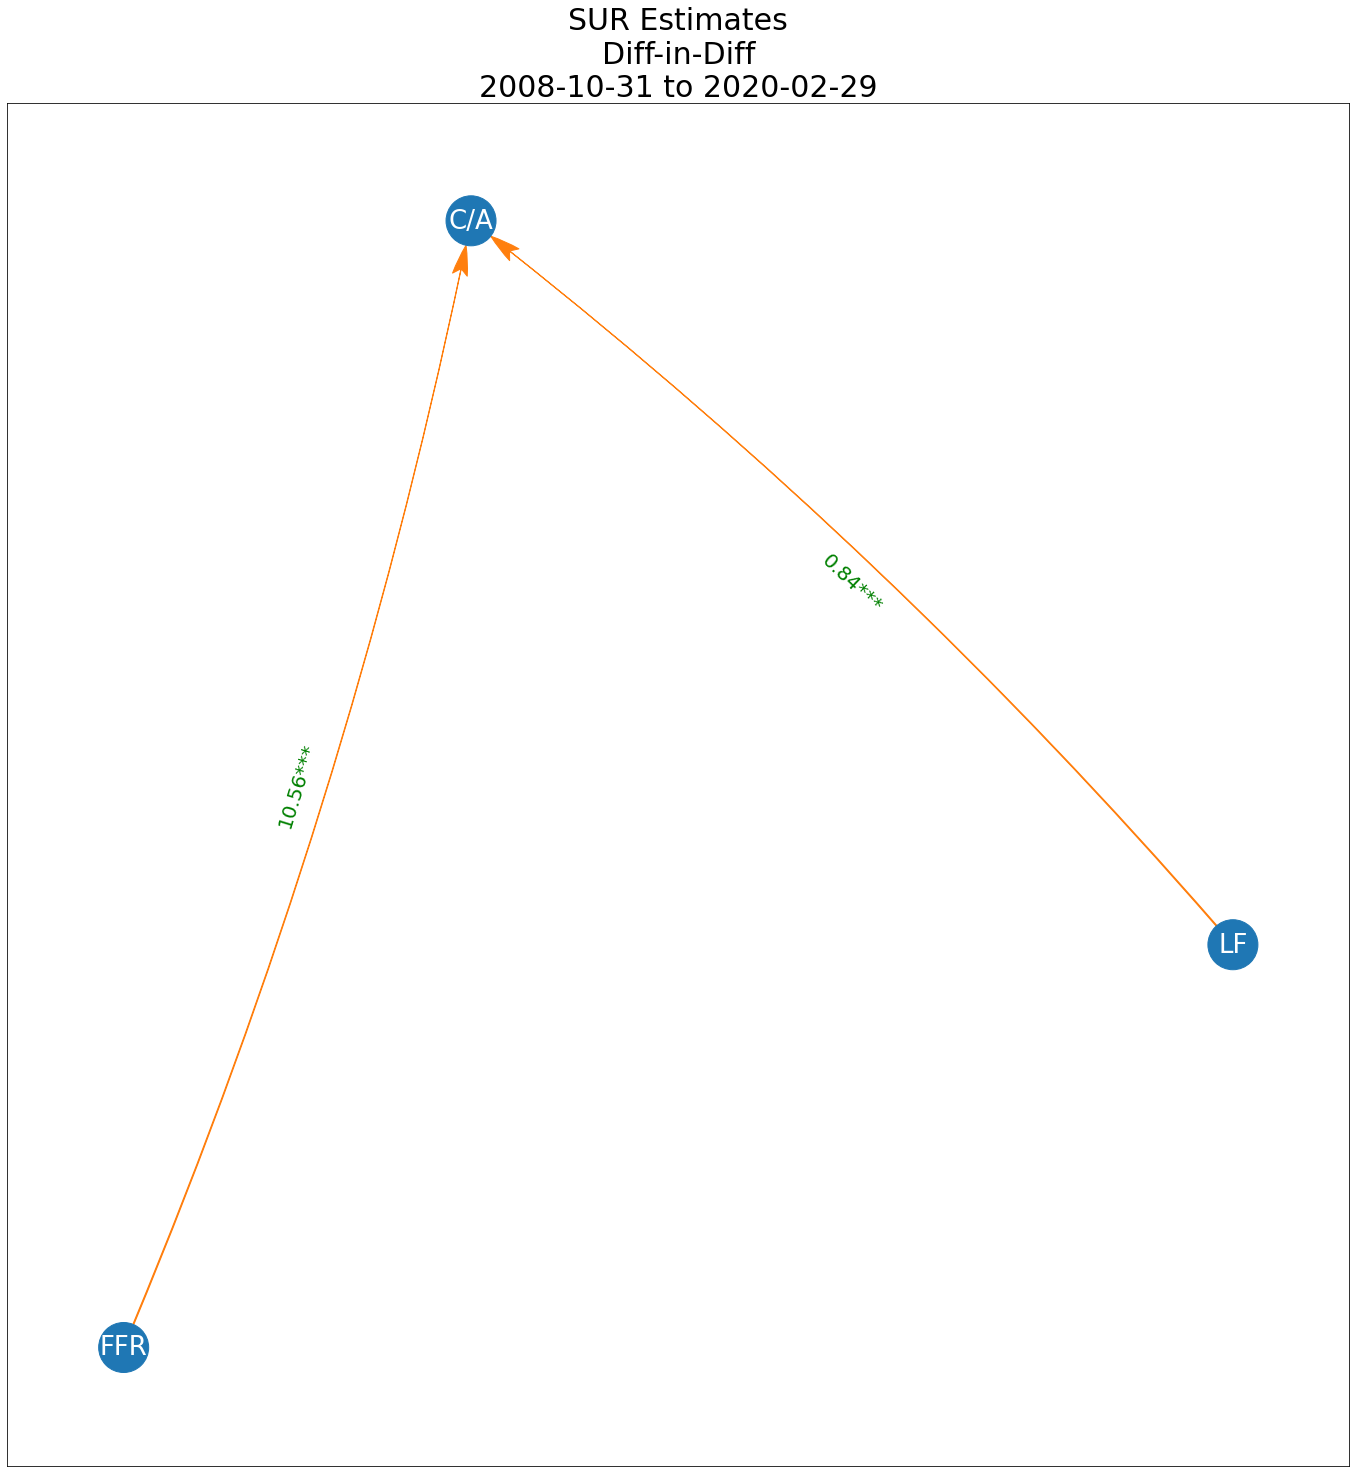

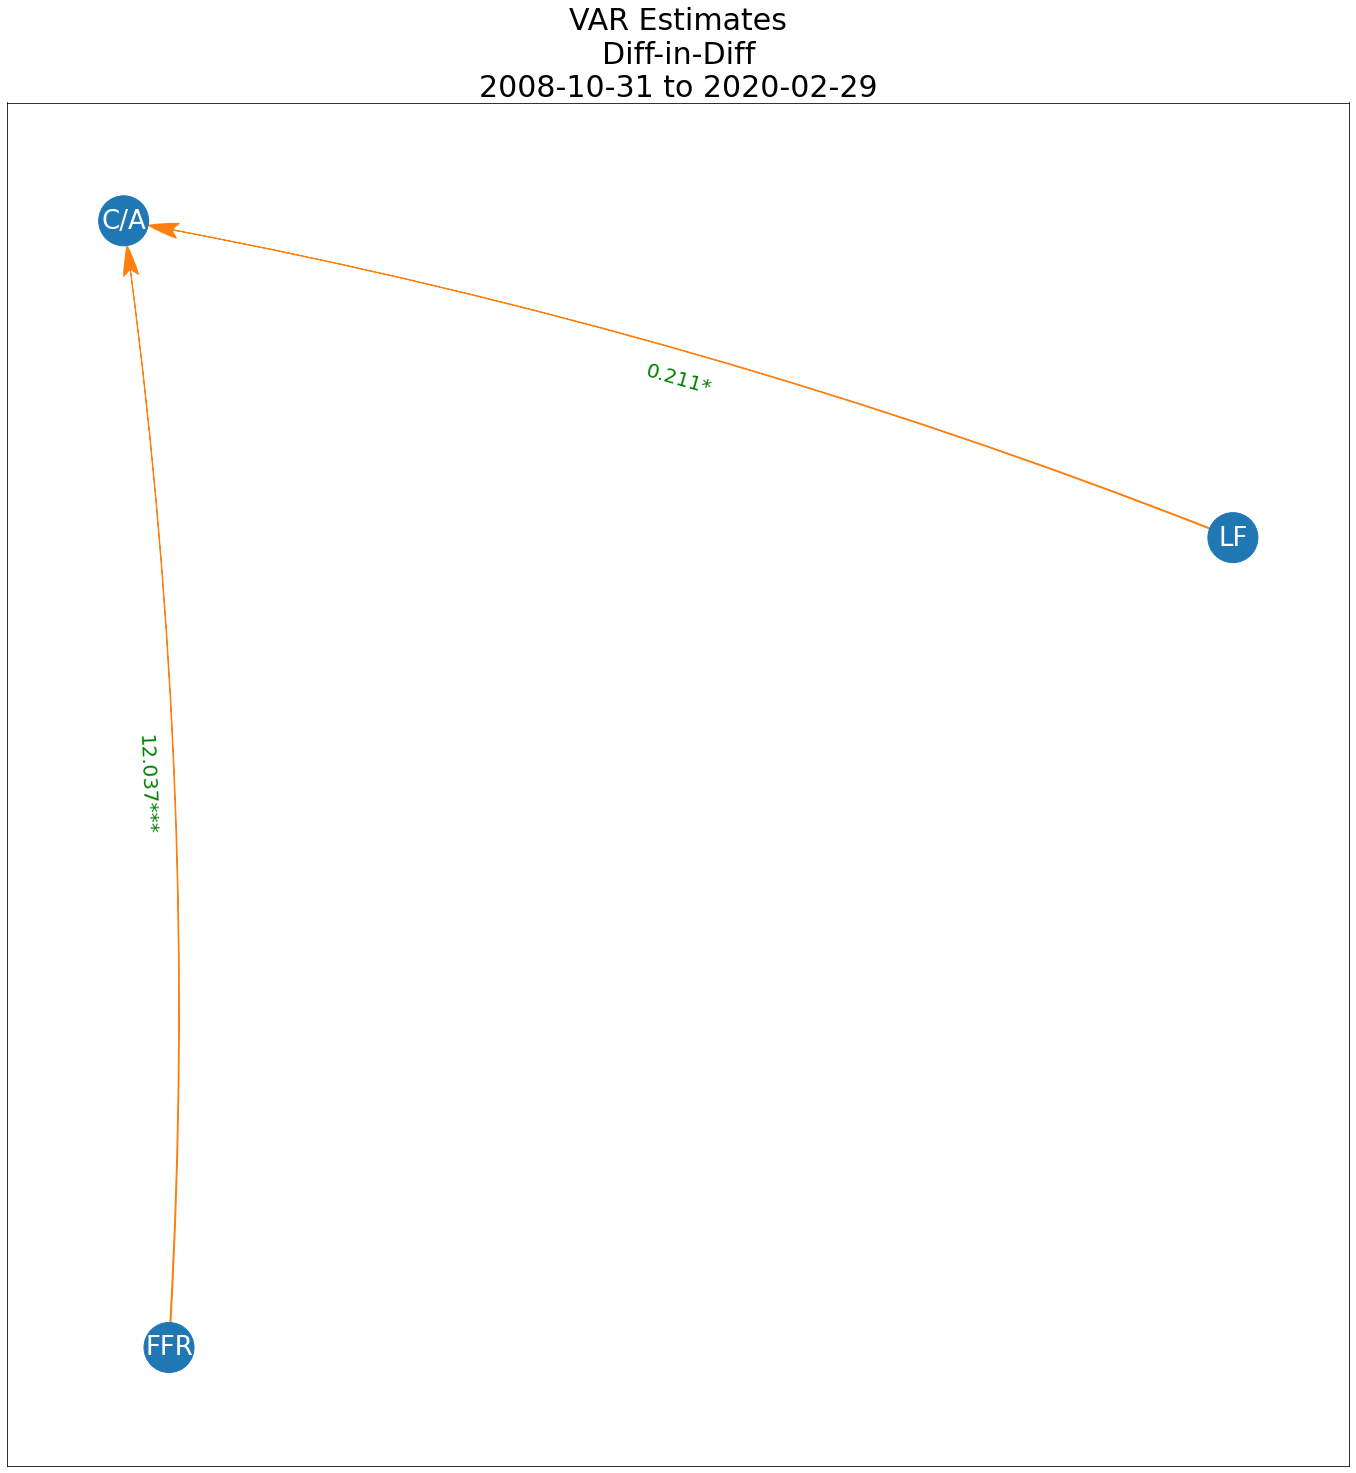

Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 47.76it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  8.72it/s]

C/A
Sink           C/A        FFR         LF
Source                                  
C/A Lag  -0.958***  -0.028***  -0.159***
FFR Lag  12.037***      0.094   8.418***
LF Lag      0.211*     -0.011     -0.2**



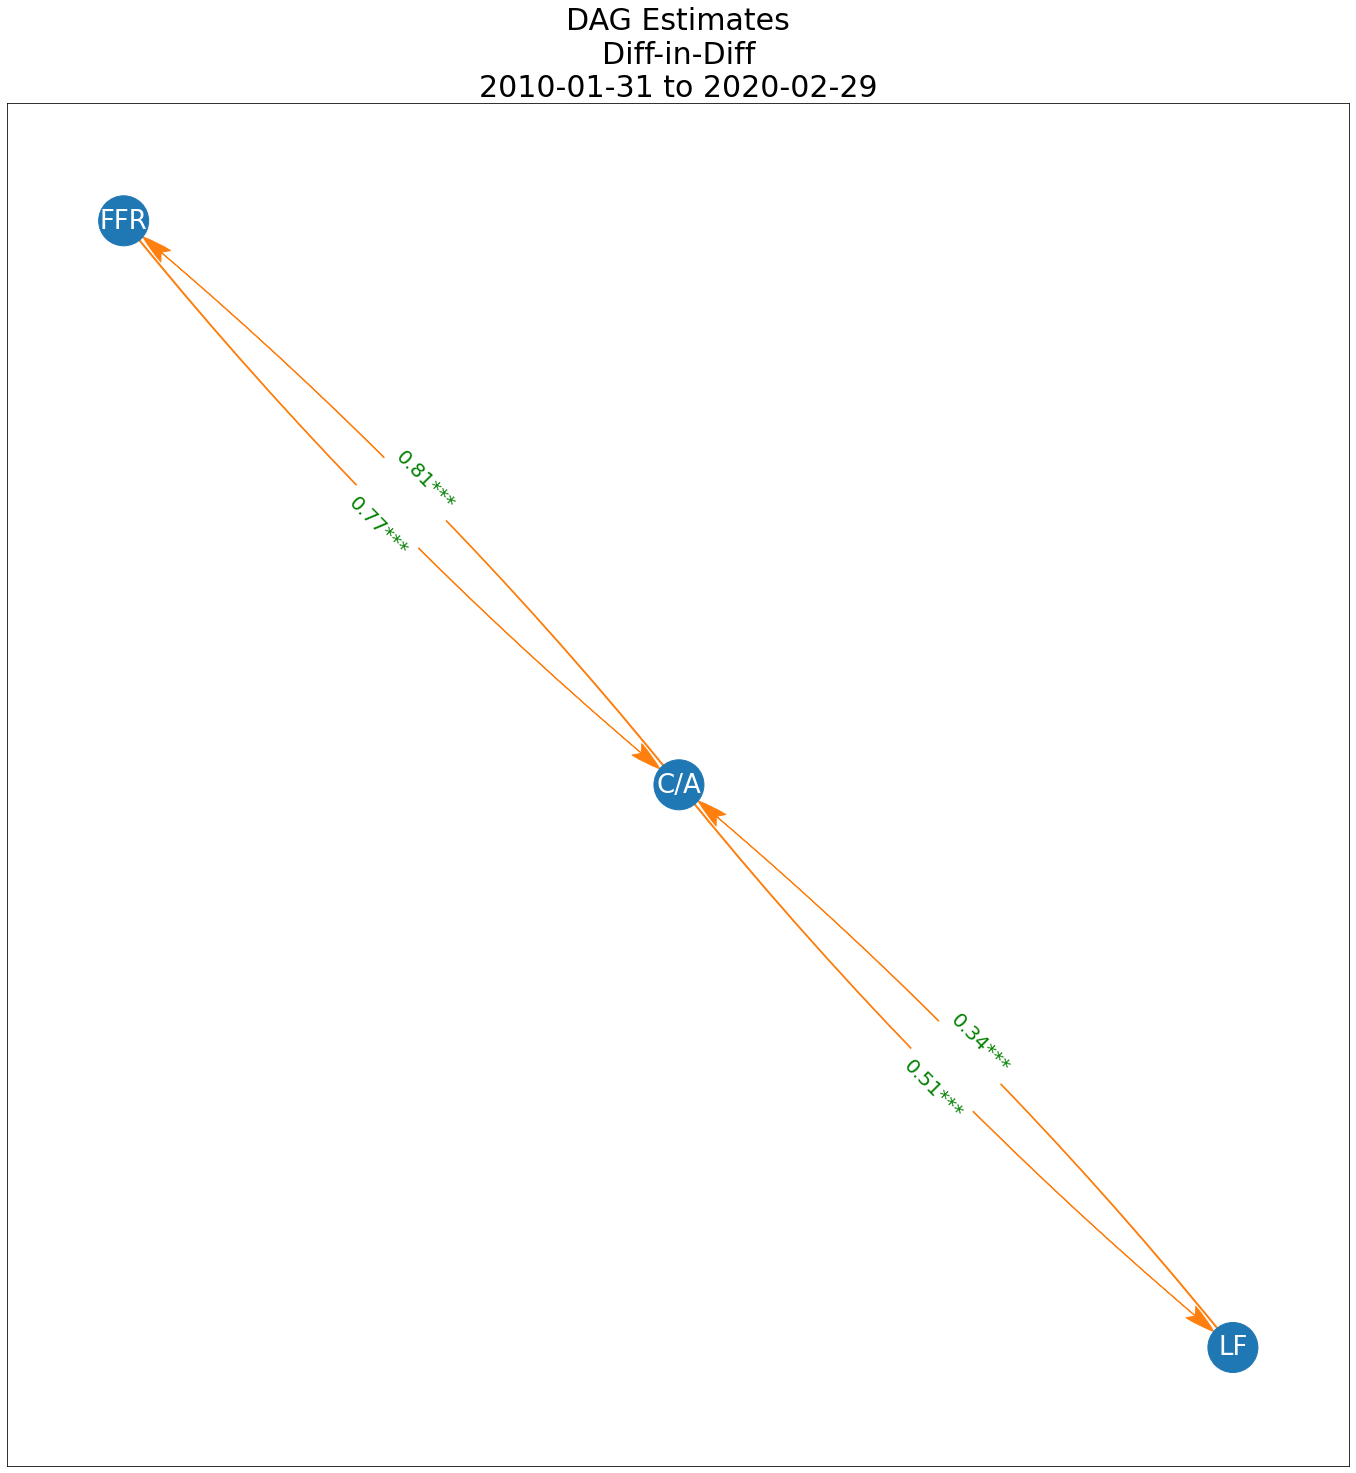

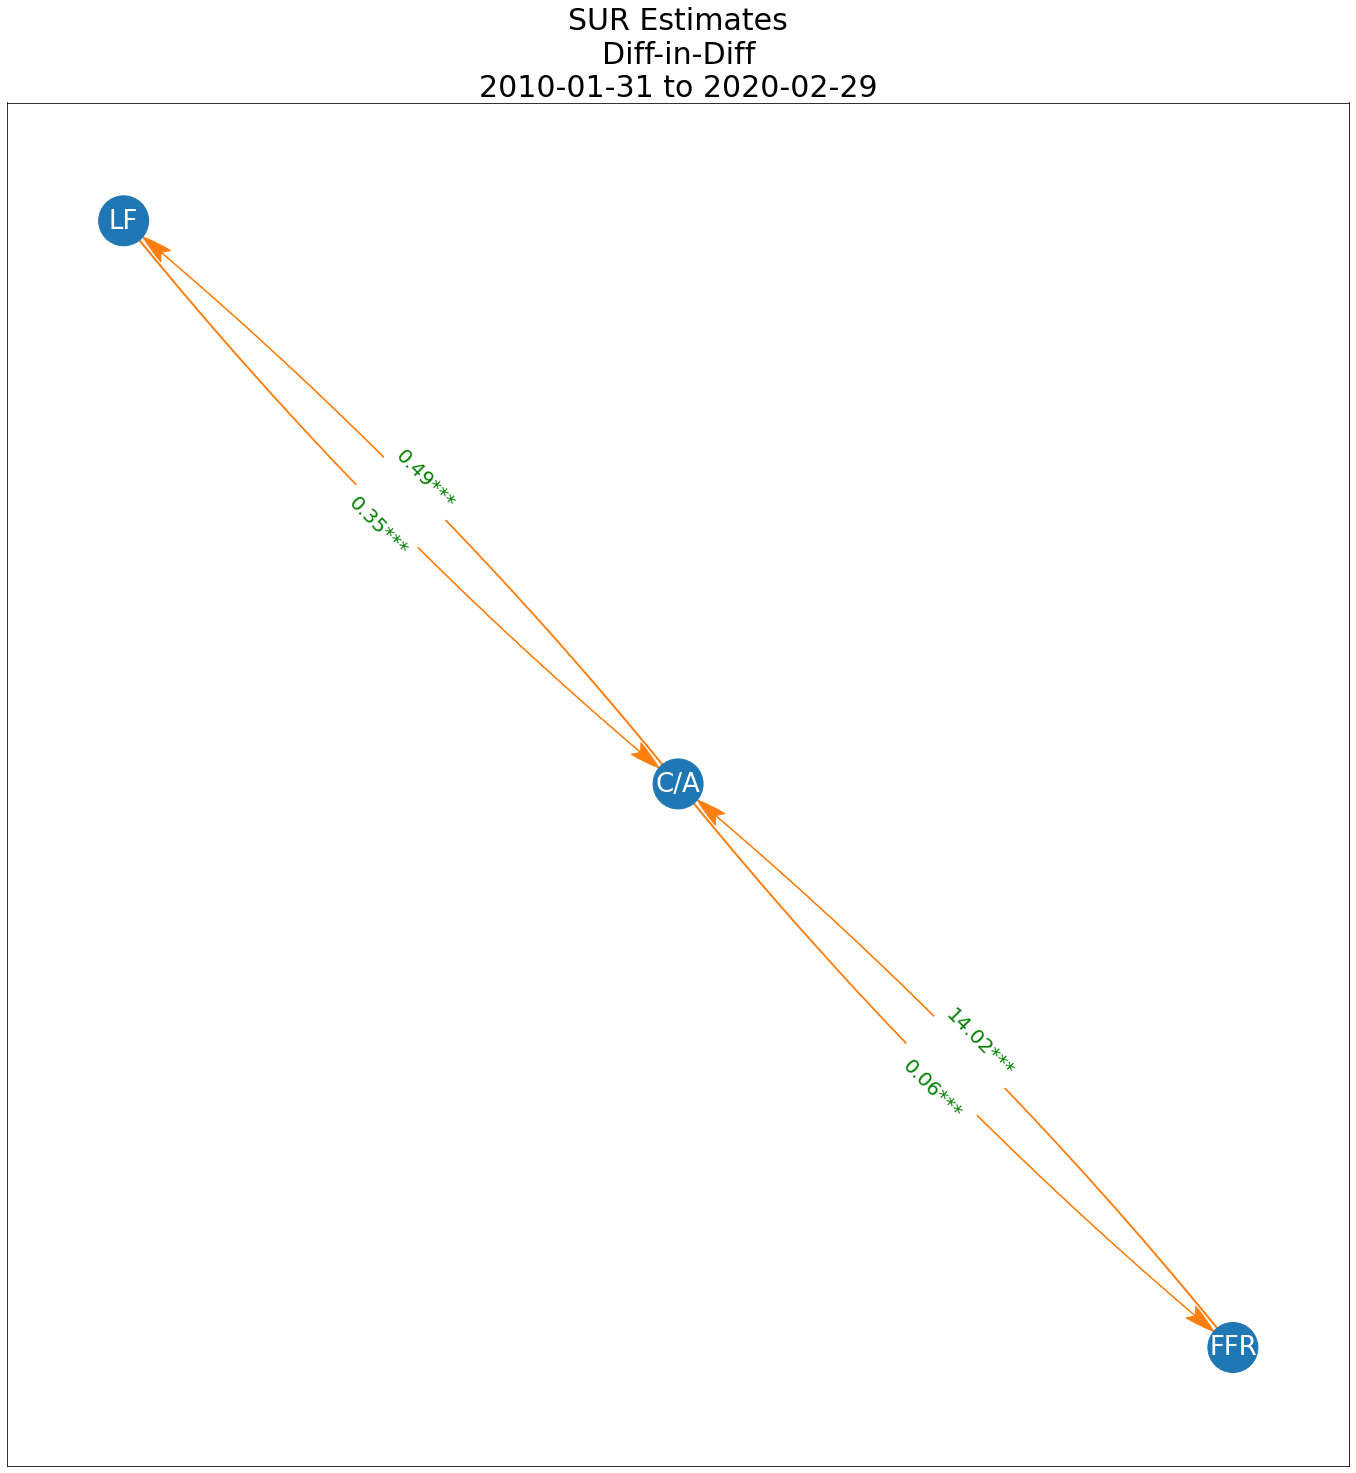

C:\Users\JLCat\GithubRepositories\ProjectRepositories\MappingTheFederalReserve'sResponseFunctionWithDirectedAcyclicGraphs\datlib\DAG.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_data.dropna(inplace = True)
C:\Users\JLCat\GithubRepositories\ProjectRepositories\MappingTheFederalReserve'sResponseFunctionWithDirectedAcyclicGraphs\datlib\DAG.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_data.dropna(inplace = True)


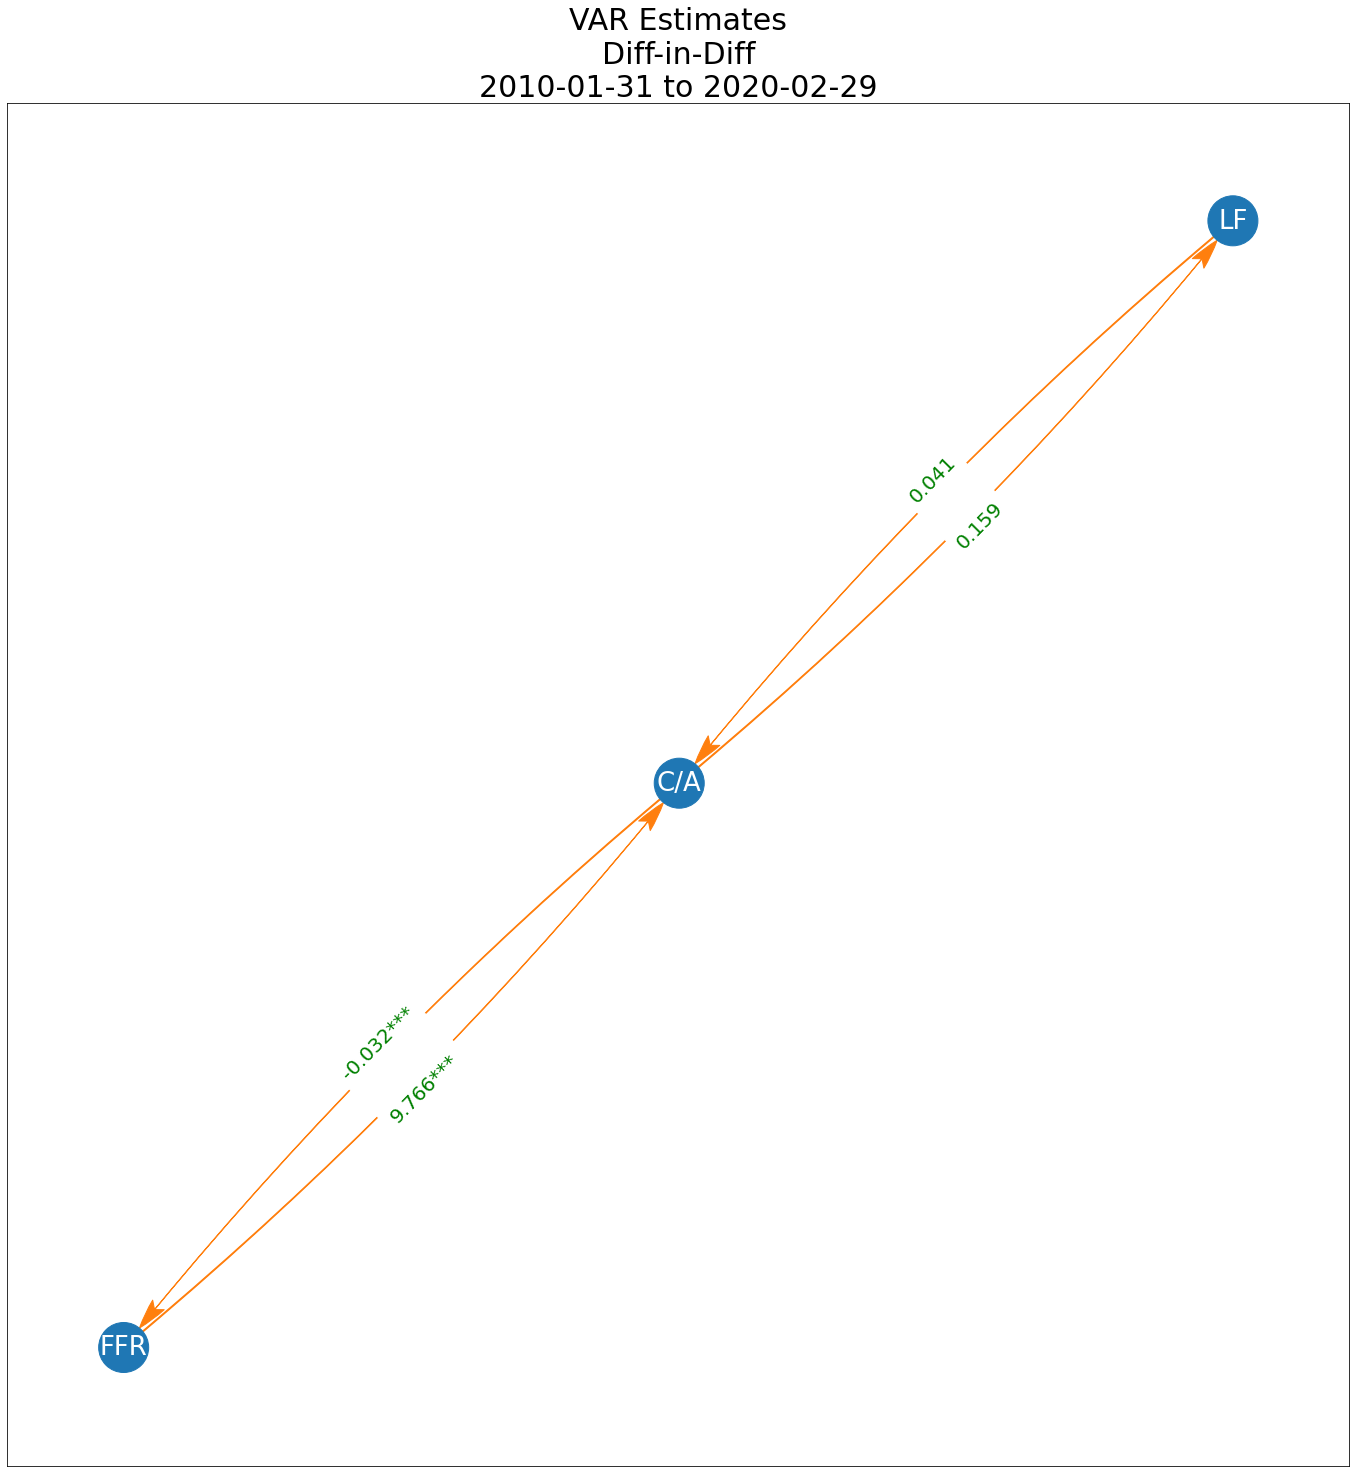

LF
Sink           C/A        LF
Source                      
C/A Lag  -0.326***     0.159
LF Lag     -0.261*  -0.454**

FFR
Sink          C/A        FFR
Source                      
C/A Lag  -0.68***  -0.032***
FFR Lag  9.556***   0.426***

C/A
Sink           C/A        FFR         LF
Source                                  
C/A Lag  -0.699***  -0.029***  -0.235***
FFR Lag   9.766***   0.395***  10.288***
LF Lag       0.041     -0.006    -0.136*



In [17]:
from datlib.DAG import *
from collections import OrderedDict
from linearmodels.system import SUR
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats


plt.rcParams.update({"font.size":20})

pd.to_datetime(data['Date'])
data.set_index("Date")

rename_dct = {"Effective":"FFR",
             "Circulation / Total":"C/A",
              "Circulation Growth":"C",
             "Assets Growth":"A",
              "Function":"LF",
             "Inflation":"$\pi$",
             "Unemployment":"U"}
sig_vals = [.05, .01, .001]


def add_lags(data, lags=12 / year):
    for key in data:
        for i in range(1, lags + 1):
            new_key = key +" Lag" * i
            data[new_key] = var_data[key].shift(year * i)

def rename_vars(rename_data, rename_dct):
    for key in rename_data:
        for rename_key in rename_dct:
            if rename_key in key:
                rename_data.rename(columns={key:rename_dct[rename_key]}, inplace = True)                


                
# only estimate twice differenced data since a some variables fail to reject the null
diffs = [" Diff-in-Diff"]
pp = PdfPages("MacroDAGs.pdf")
reg_dict = {}
lags = int(round(12 / year,0))

for diff in diffs:
    reg_dict[diff] = {}
    # only test the aggregated data, since the hypothesis is that:
        # 1) currency and total assets are indicate relative provision of liquidity
        # 2) loss function variables are targeted together
    plot_vars_dct = {"Aggregated C-A": ["Effective Federal Funds Rate" +diff + " (%)",
                         "Currency in Circulation / Total Assets" + diff,
                        "Loss Function" + diff],
#                      "Aggregated C&A":["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Loss Function" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
#                      "Disaggregated C-A":["Effective Federal Funds Rate" +diff + " (%)",
#                         "Currency in Circulation / Total Assets" + diff,
#                          "Unemployment Loss" + diff,
#                         "Inflation Loss" + diff],
#                      "Disaggregated C&A":["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Unemployment Loss Sq" + diff,
#                         "Inflation Loss Sq" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                    }

    sig = 0.05
    variant = "parallel"
    ci_test = "pearsonr"
    
    for i, plot_vars in plot_vars_dct.items():
        reg_dict[diff][i] = {}
        var_data = data[plot_vars]
        rename_vars(var_data, rename_dct)
        add_lags(var_data, lags)
        var_data.dropna(inplace=True)
        start_end_list = [(str(var_data.index[0])[:10],"2008-09-30"),
#                   (str(data.index[0])[:10], "2020-02-29"),
                  ("2008-10-31", "2020-02-29"),
                  ("2010-01-31", "2020-02-29")]        

        # slice dfs by date range, house in dfs {}
        dfs = {}
        for start,end in start_end_list:
            dfs[start +" to " + end] =  var_data.loc[start:end].copy() 

        # use dates (key) to track dates for which hypotheses are tested
        for dates, select_df in dfs.items():
            keys = [k for k in select_df if "Lag" not in k]
            dag_df = select_df[keys].dropna()
            # construct dag, save directed edges
            edges = DAG(dag_df, variant, ci_test, sig)
            # construct graphs with PC labels
            graph_DAG(edges, 
                      dag_df, 
                      pp = pp, 
                      title = "DAG Estimates\n"+diff.replace(" ", "") + "\n" + dates)
            # identify sink nodes in directed dag edges, use info to detect structure of regressions
            #  additional graphs with marginal effects from SUR and VAR are constructed
            sink_source = identify_sink_nodes(edges)
            filename = i + " " + diff + "DAGOLS " + dates 
            DAG_OLS(dag_df, sink_source, filename, pp, diff, dates, sig_vals)            
            filename = i + " " + diff + "DAGVAR " + dates 
            DAG_VAR(select_df.dropna(), sink_source, filename, pp, diff, dates, sig_vals)

pp.close()

Text(0.5, 1.0, 'January 2010 - July 2020')

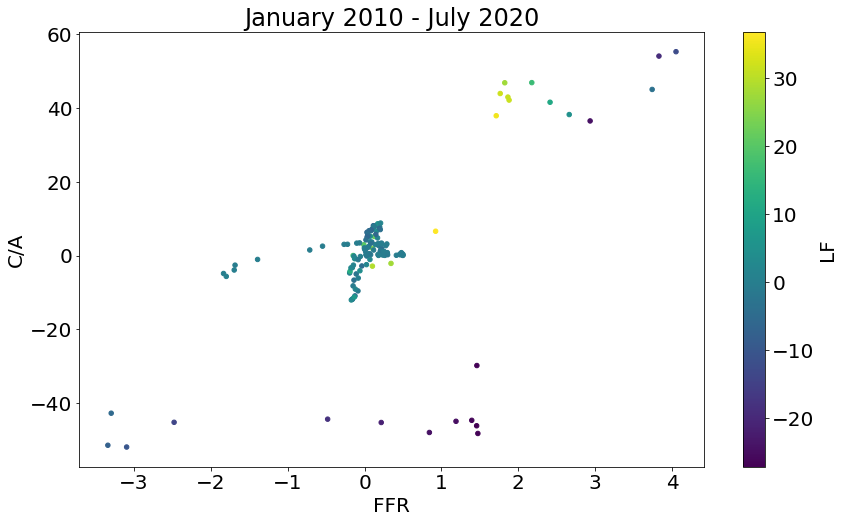

In [18]:
fig, ax = plt.subplots(figsize = (14,8))
var_data.rename(columns={key:key.replace(" Diff-in-Diff", "") for key in var_data}).loc["2008-10-31":"2020-02-29"].plot.scatter(
                                                x = "FFR", 
                                                 y = "C/A", 
                                                 c = "LF", 
                                                 cmap = "viridis", 
                                                 ax = ax)
ax.set_title("January 2010 - July 2020")

<AxesSubplot:xlabel='Currency in Circulation / Total Assets Diff-in-Diff', ylabel='Unemployment Rate Diff-in-Diff'>

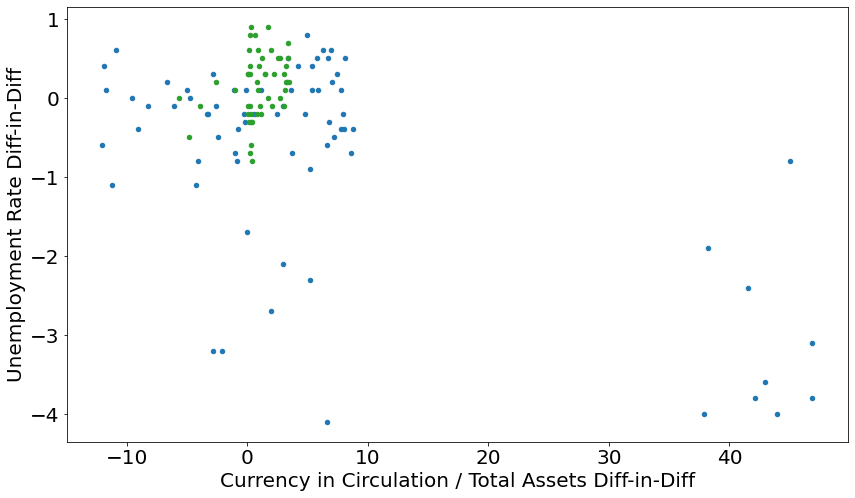

In [19]:
fig, ax = plt.subplots(figsize = (14,8))
data[data["Effective Federal Funds Rate (%)"] <= 0.25].loc["2010-01-31":"2020-02-29"].plot.scatter(x = "Currency in Circulation / Total Assets Diff-in-Diff", 
                                                 y = "Unemployment Rate Diff-in-Diff", 
                                                 c = "C0", 
                                                 ax = ax)
data[data["Effective Federal Funds Rate (%)"] > 0.25].loc["2010-01-31":"2020-02-29"].plot.scatter(x = "Currency in Circulation / Total Assets Diff-in-Diff", 
                                                 y = "Unemployment Rate Diff-in-Diff", 
                                                 c = "C2", 
                                                 ax = ax)

(array([-15., -10.,  -5.,   0.,   5.,  10.,  15.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

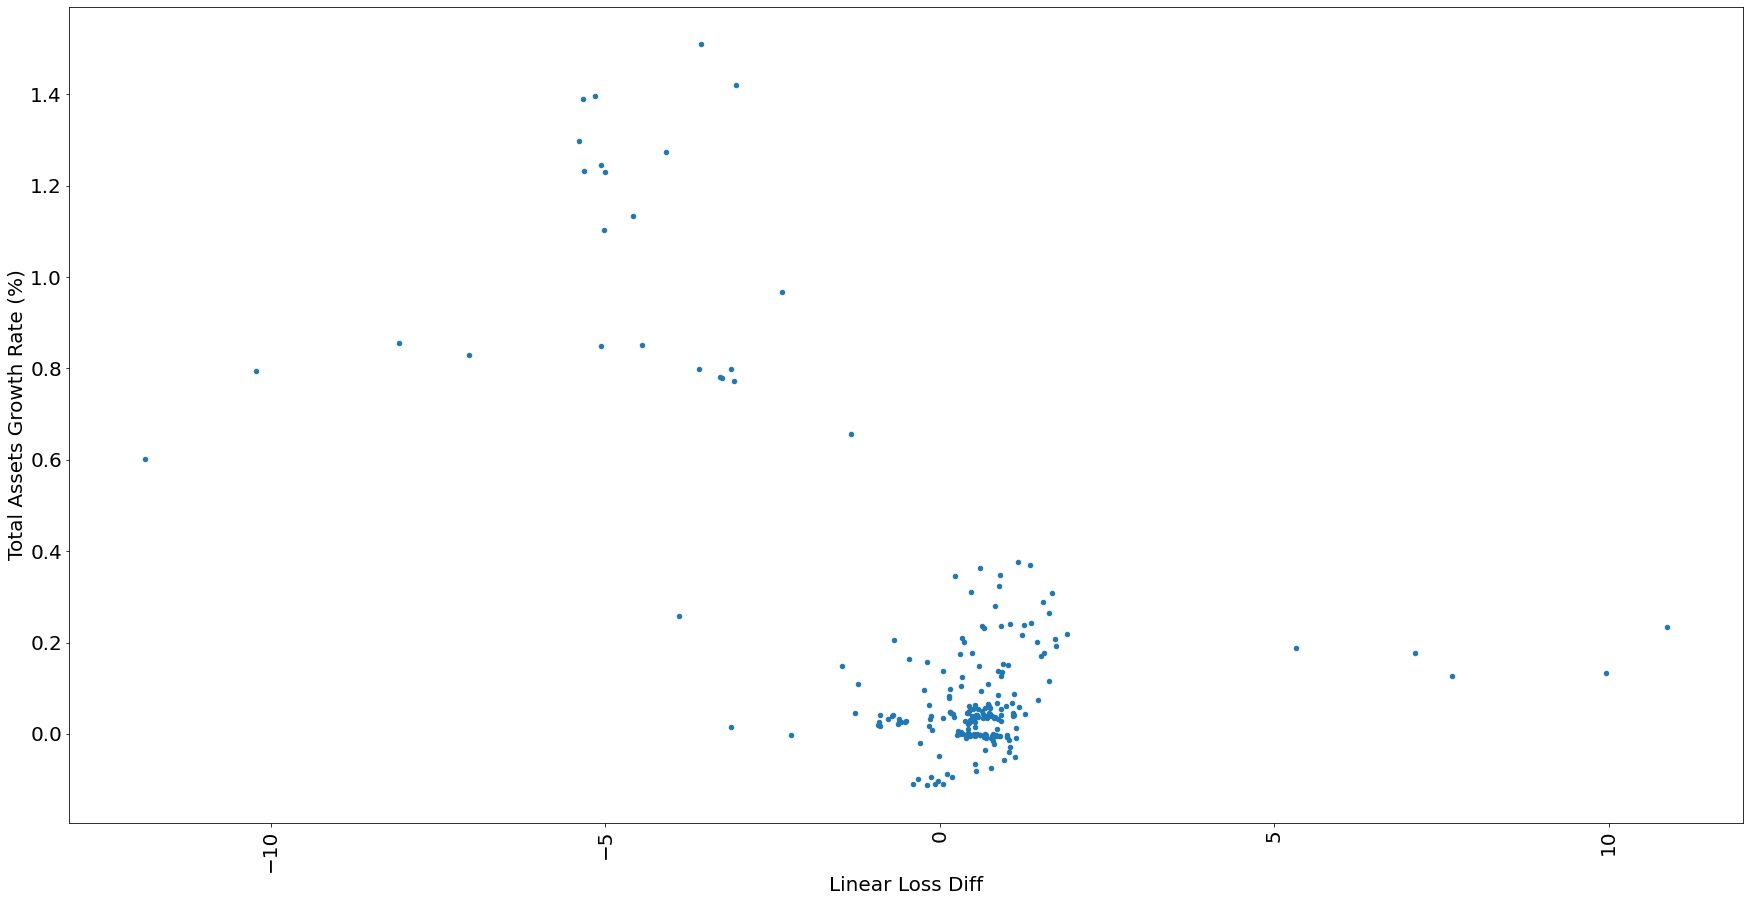

In [20]:
fig, ax = plt.subplots(figsize = (30,15))
data[["Linear Loss Diff", "Total Assets Growth Rate (%)"]].plot.scatter(x = "Linear Loss Diff", y = "Total Assets Growth Rate (%)", ax = ax)
plt.xticks(rotation=90)


(array([-14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

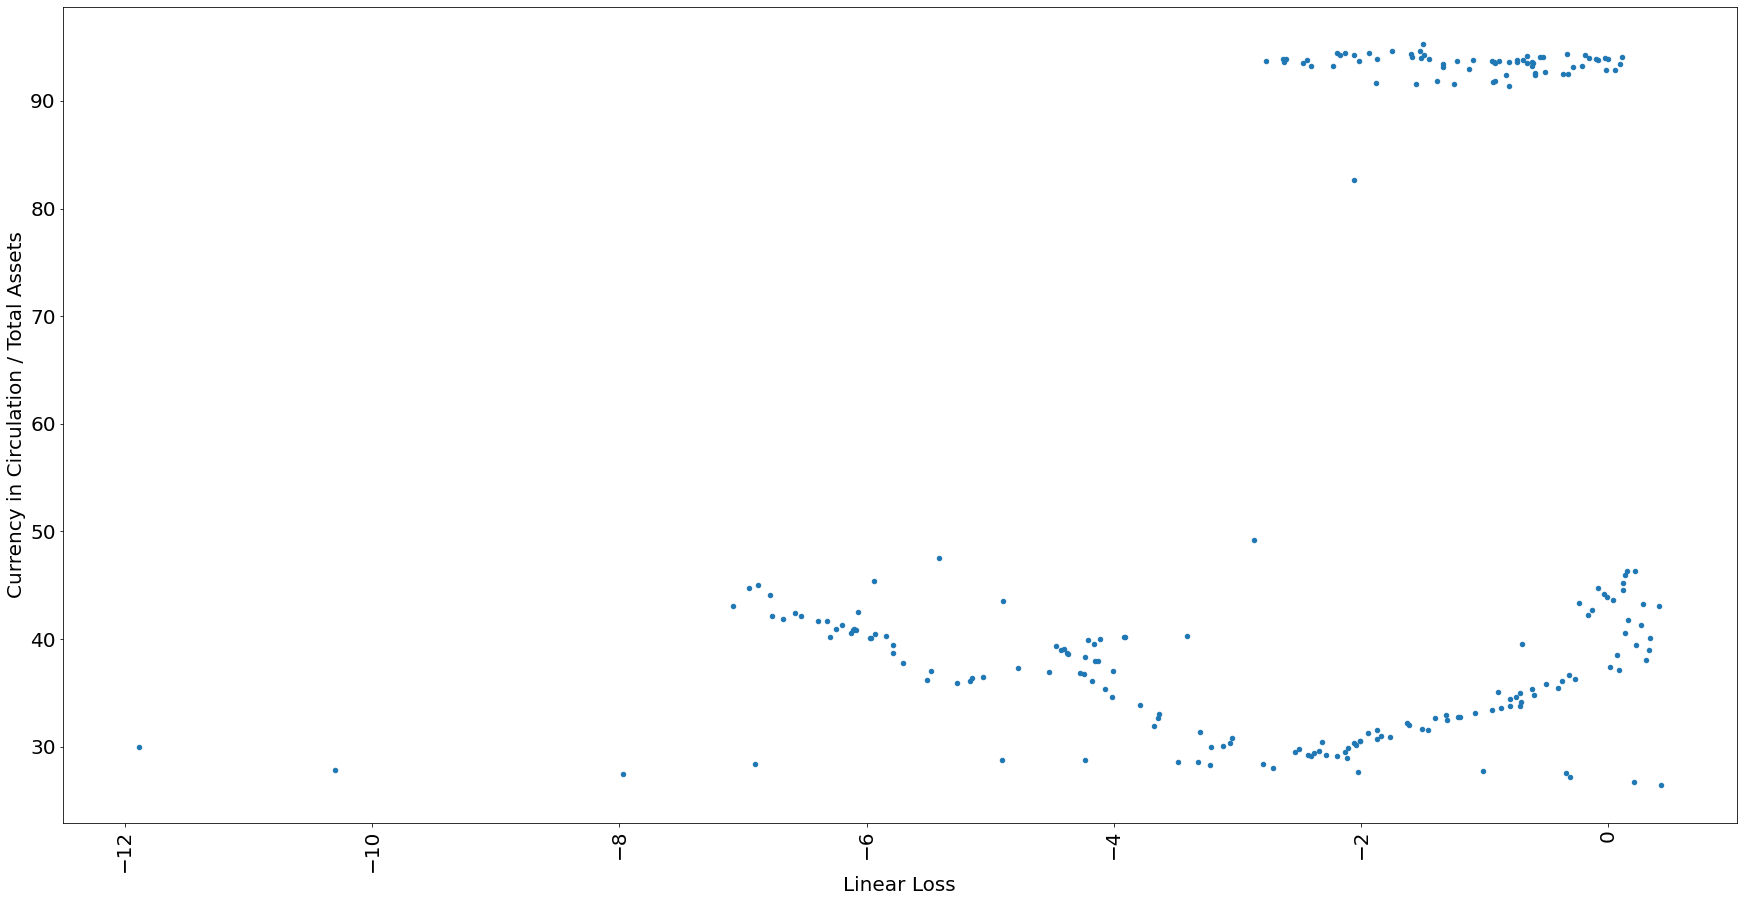

In [21]:
fig, ax = plt.subplots(figsize = (30,15))
data.iloc[:-1].plot.scatter(x = "Linear Loss", y = "Currency in Circulation / Total Assets", ax = ax)
plt.xticks(rotation=90)
